# Analyse exploratoire des données

In [214]:
# Importation des librairies
from datetime import time, timedelta
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [215]:
data = pd.read_csv('../output/cleaned_data/data_cleaned.csv', parse_dates=['date'])
data.time_taken = pd.to_timedelta(data.time_taken)
data.head()

,date,airline,dep_time,from,time_taken,stop,arr_time,to,price,class
0,2022-02-11,Air India,18:00:00,Delhi,0 days 02:00:00,0-stop,20:00:00,Mumbai,25612,business
1,2022-02-11,Air India,19:00:00,Delhi,0 days 02:15:00,0-stop,21:15:00,Mumbai,25612,business
2,2022-02-11,Air India,20:00:00,Delhi,1 days 00:45:00,1-stop,20:45:00,Mumbai,42220,business
3,2022-02-11,Air India,21:25:00,Delhi,1 days 02:30:00,1-stop,23:55:00,Mumbai,44450,business
4,2022-02-11,Air India,17:15:00,Delhi,0 days 06:40:00,1-stop,23:55:00,Mumbai,46690,business


In [216]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300182 entries, 0 to 300181
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype          
---  ------      --------------   -----          
 0   date        300182 non-null  datetime64[ns] 
 1   airline     300182 non-null  object         
 2   dep_time    300182 non-null  object         
 3   from        300182 non-null  object         
 4   time_taken  300182 non-null  timedelta64[ns]
 5   stop        300182 non-null  object         
 6   arr_time    300182 non-null  object         
 7   to          300182 non-null  object         
 8   price       300182 non-null  int64          
 9   class       300182 non-null  object         
dtypes: datetime64[ns](1), int64(1), object(7), timedelta64[ns](1)
memory usage: 22.9+ MB


## Analyse Univariée

### Variables qualitatives

In [217]:
# Variable Date
date_grouped = data.groupby(data['date'].dt.to_period('D')).agg(count=('date', 'count')).reset_index()
date_grouped['date'] = date_grouped['date'].dt.to_timestamp()
date_grouped.head()

,date,count
0,2022-02-11,1926
1,2022-02-12,4031
2,2022-02-13,4250
3,2022-02-14,5078
4,2022-02-15,5395


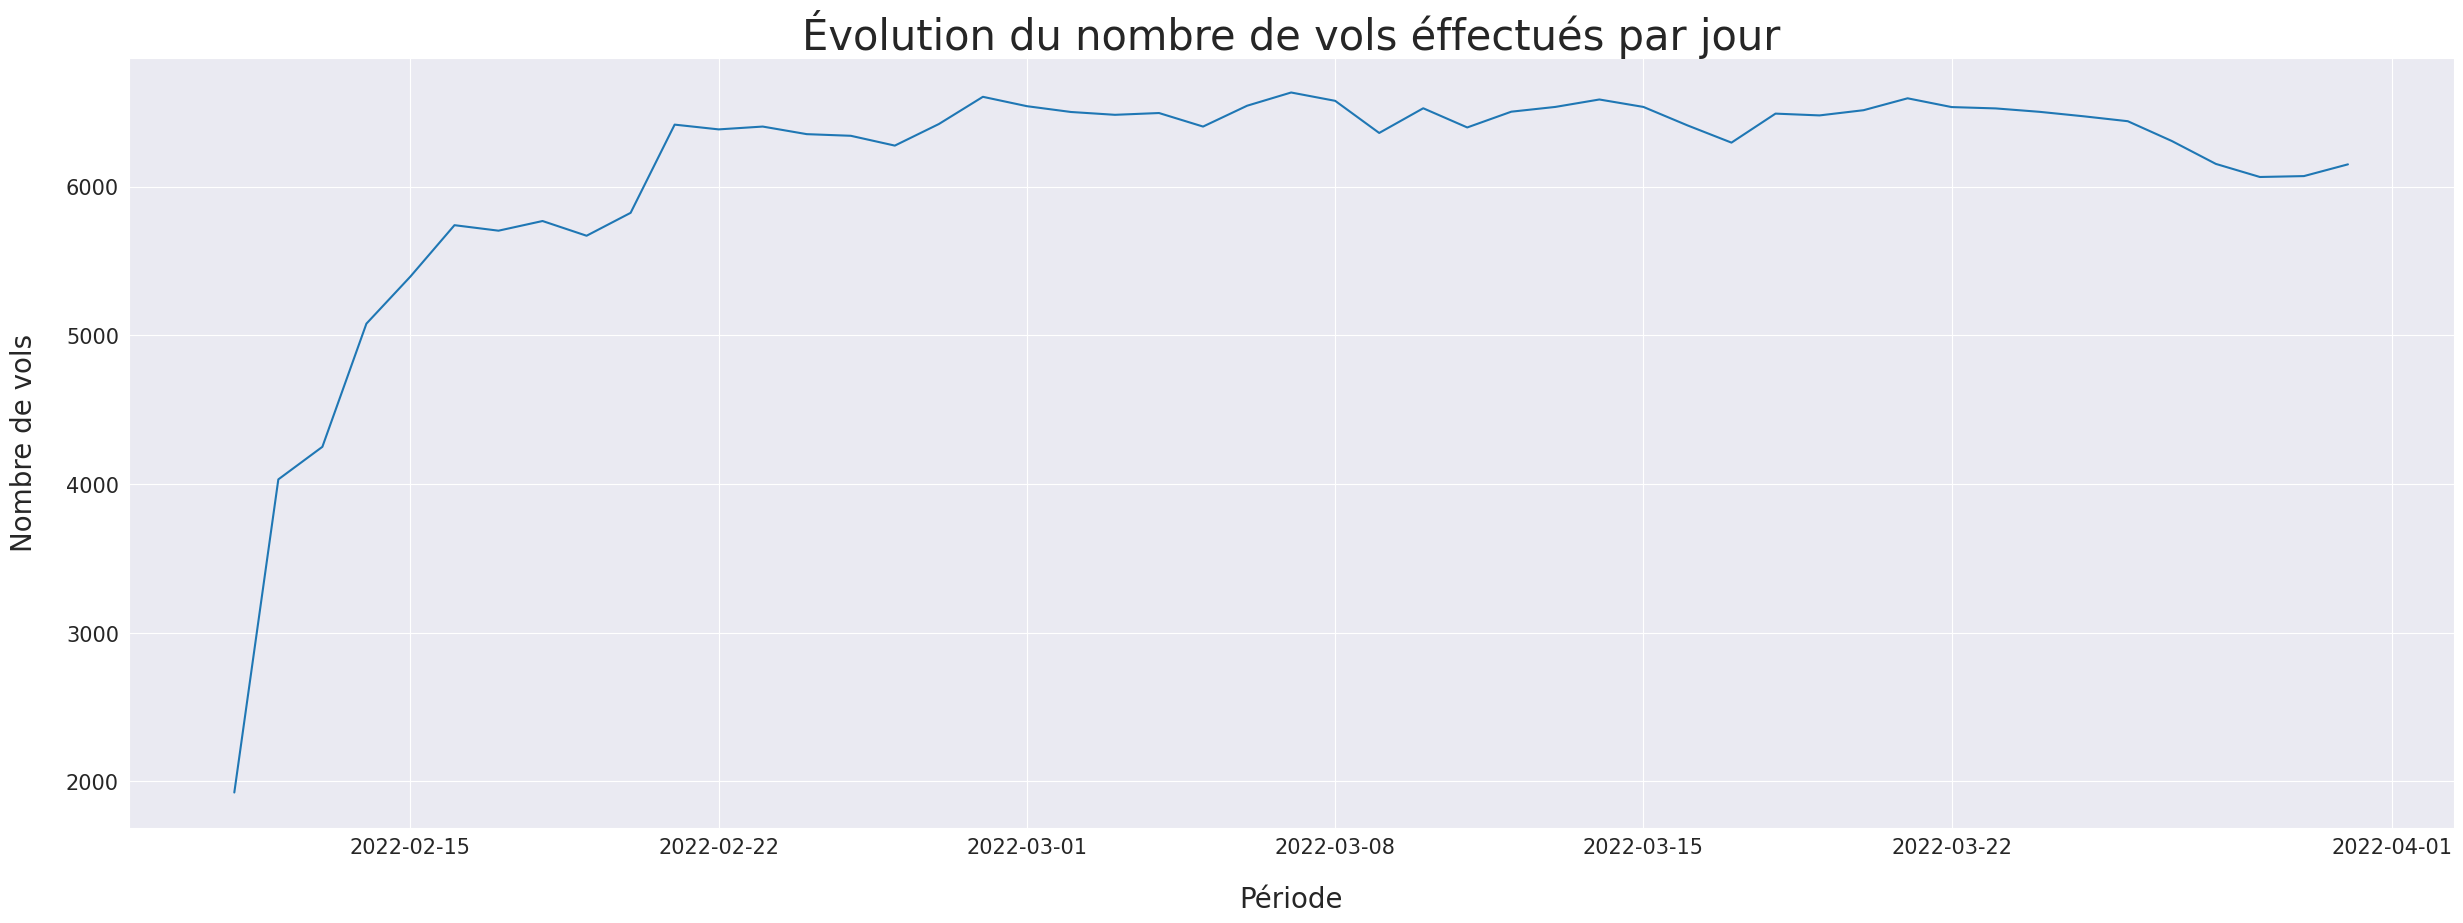

In [218]:
# Visualisation
plt.figure(figsize=(30, 10))
plt.title('Évolution du nombre de vols éffectués par jour', fontsize=30)
plt.xlabel("Période", fontsize=20, labelpad=20); plt.ylabel("Nombre de vols", fontsize=20, labelpad=20)
plt.tick_params(labelsize=15)
sns.lineplot(data=date_grouped, x='date', y='count')
plt.show()

On remarque une forte hausse journalière du nombre de vols éffectués entre le mois de février et mars, puis une stabilisation au cours des mois de mars et avril.

In [219]:
# Compagnie aérienne
data['airline'].value_counts()

airline
Vistara      127859
Air India     80892
Indigo        43114
GO FIRST      23145
AirAsia       16059
SpiceJet       9011
StarAir          61
Trujet           41
Name: count, dtype: int64

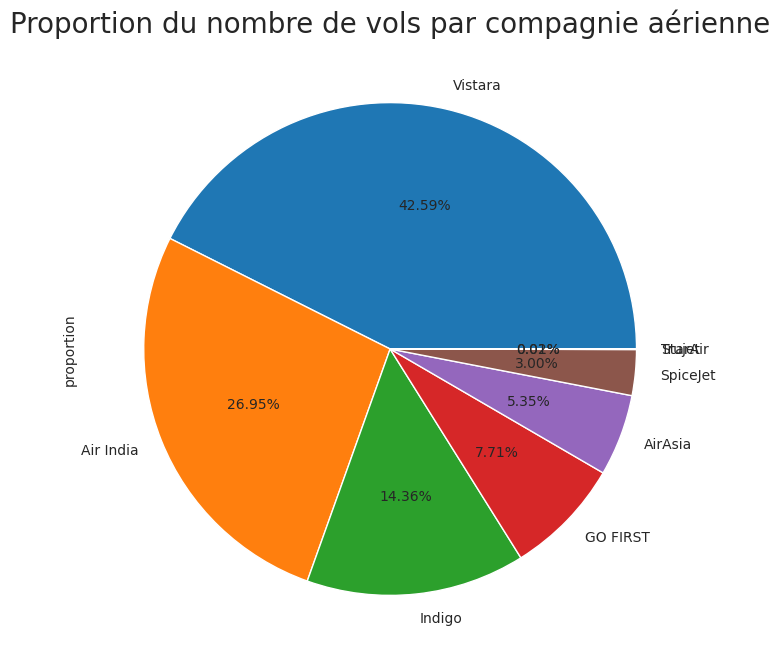

In [220]:
# Visualisation
plt.figure(figsize=(10, 8))
plt.title('Proportion du nombre de vols par compagnie aérienne', fontsize=20)
data['airline'].value_counts(normalize=True).plot(kind='pie', autopct='%.2f%%')
plt.show()

Les vols éffectués par la compagnie aérienne **Vistara** représente ici près de la moitié des vols enregistrés, puis suit la compagnie **Air India** avec 27% de vols soit un peu plus d'un quart des vols.

In [221]:
def define_period(hour):
    if time(4) <= hour < time(6):
        return 'aube'
    elif time(6) <= hour < time(12):
        return 'matin'
    elif time(12) <= hour < time(14):
        return 'midi'
    elif time(14) <= hour < time(18):
        return 'apres-midi'
    elif time(18) <= hour < time(23):
        return 'soir'
    else:
        return 'nuit'

In [222]:
# On catégorise les heures par les moments de la journée
data['dep_time'] = pd.to_datetime(data['dep_time'], format='%H:%M:%S').dt.time
data['arr_time'] = pd.to_datetime(data['arr_time'], format='%H:%M:%S').dt.time
data['dep_time'] = data['dep_time'].apply(define_period)
data['arr_time'] = data['arr_time'].apply(define_period)

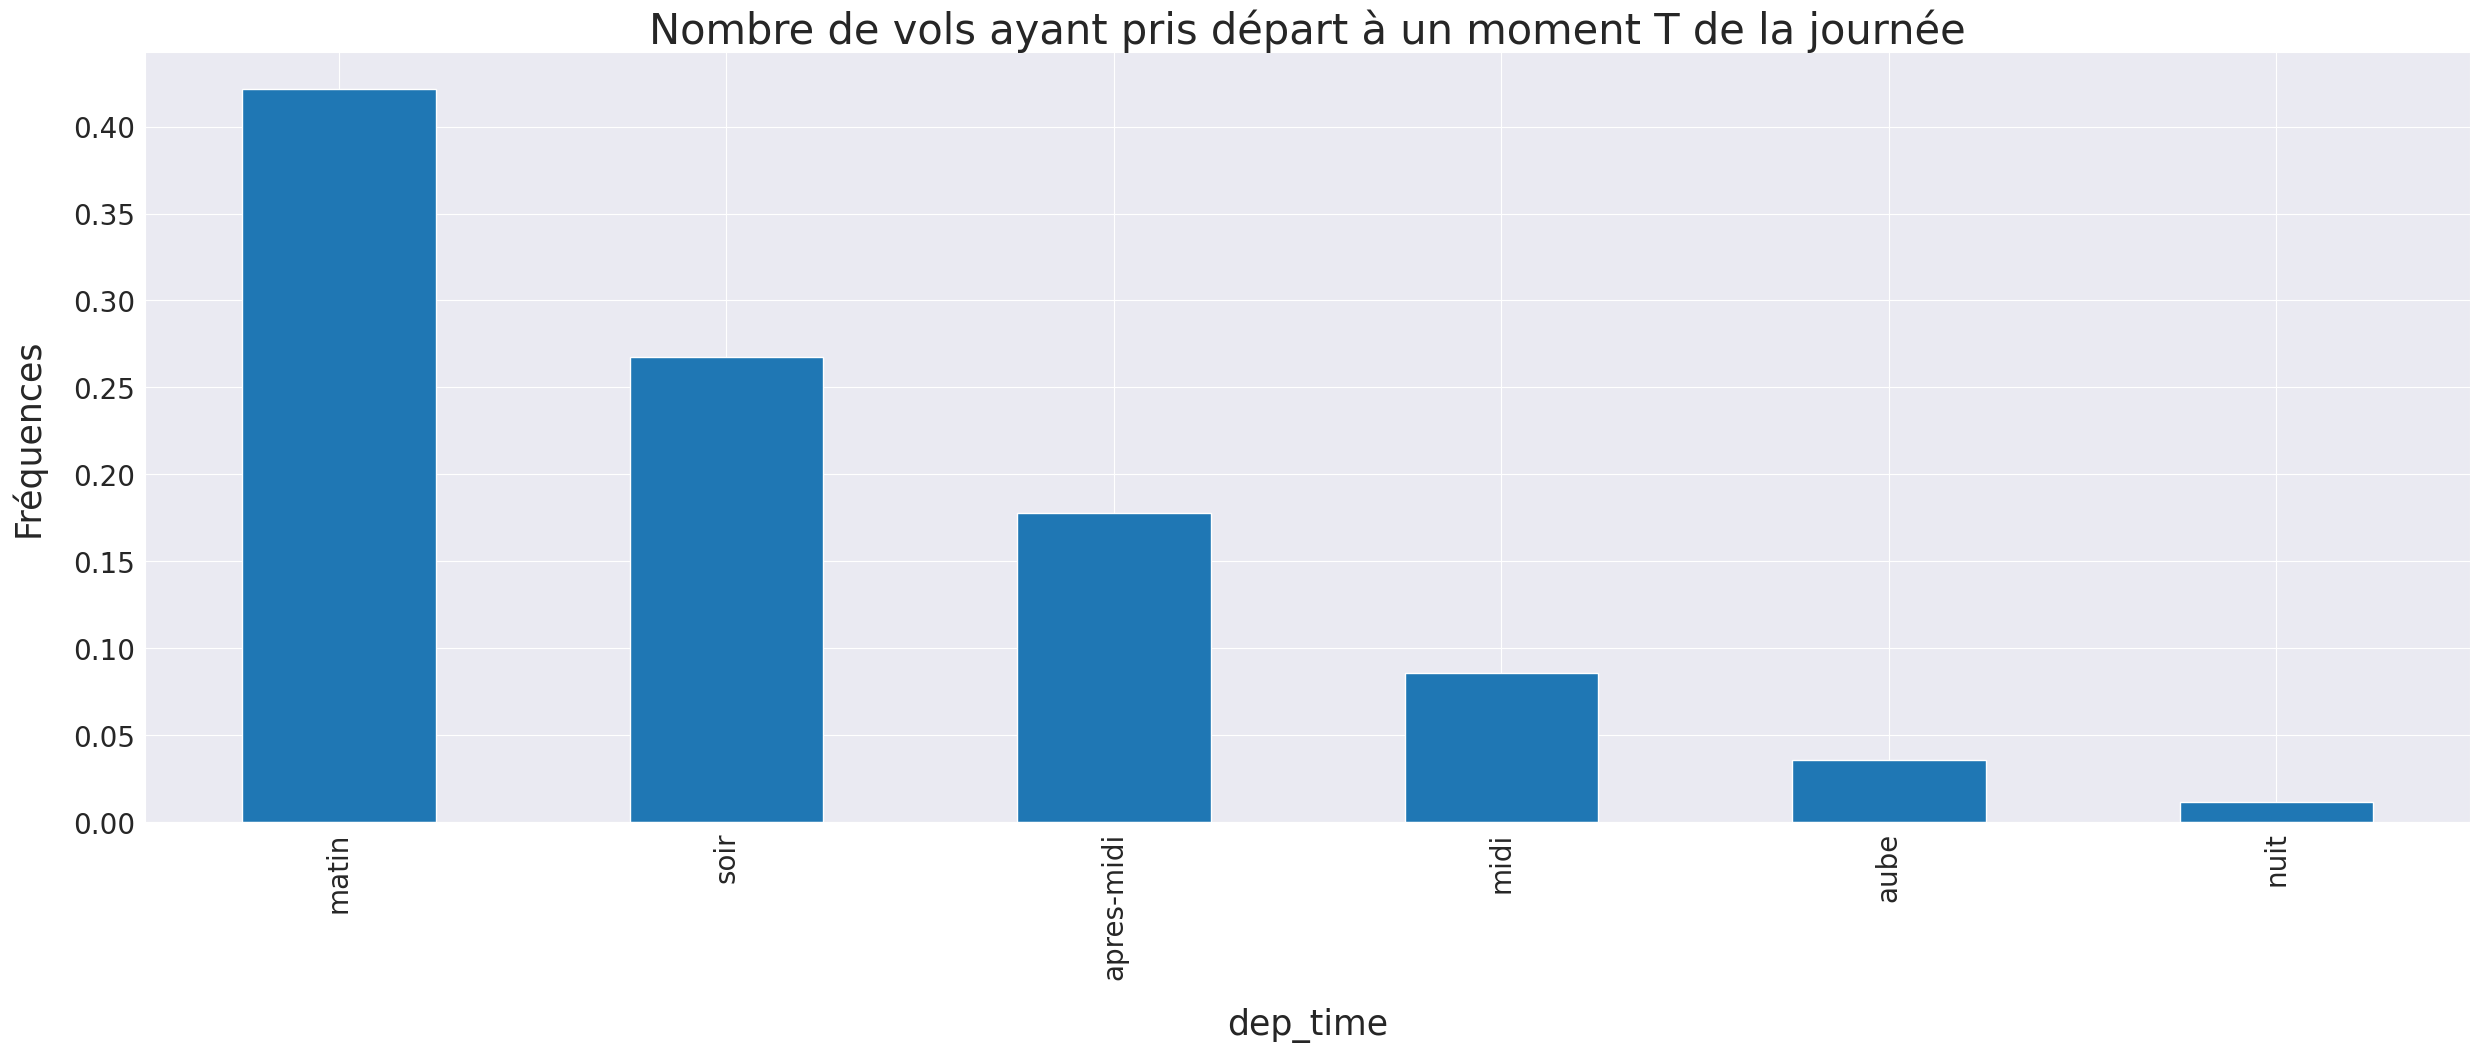

In [223]:
# Visualisation moment de départ
plt.figure(figsize=(30, 10))
plt.title('Nombre de vols ayant pris départ à un moment T de la journée', fontsize=30)
plt.xlabel('Moment de la journée', fontsize=25, labelpad=20); plt.ylabel("Fréquences", fontsize=25, labelpad=20)
plt.tick_params(labelsize=20)
data['dep_time'].value_counts(normalize=True).plot(kind='bar')
plt.show()

Les heures de départ des vols sont majoritairement le matin, soit près d'1 vol sur 2 démarre le matin. Puis vient le soir, qui représente 1 vol sur 4.

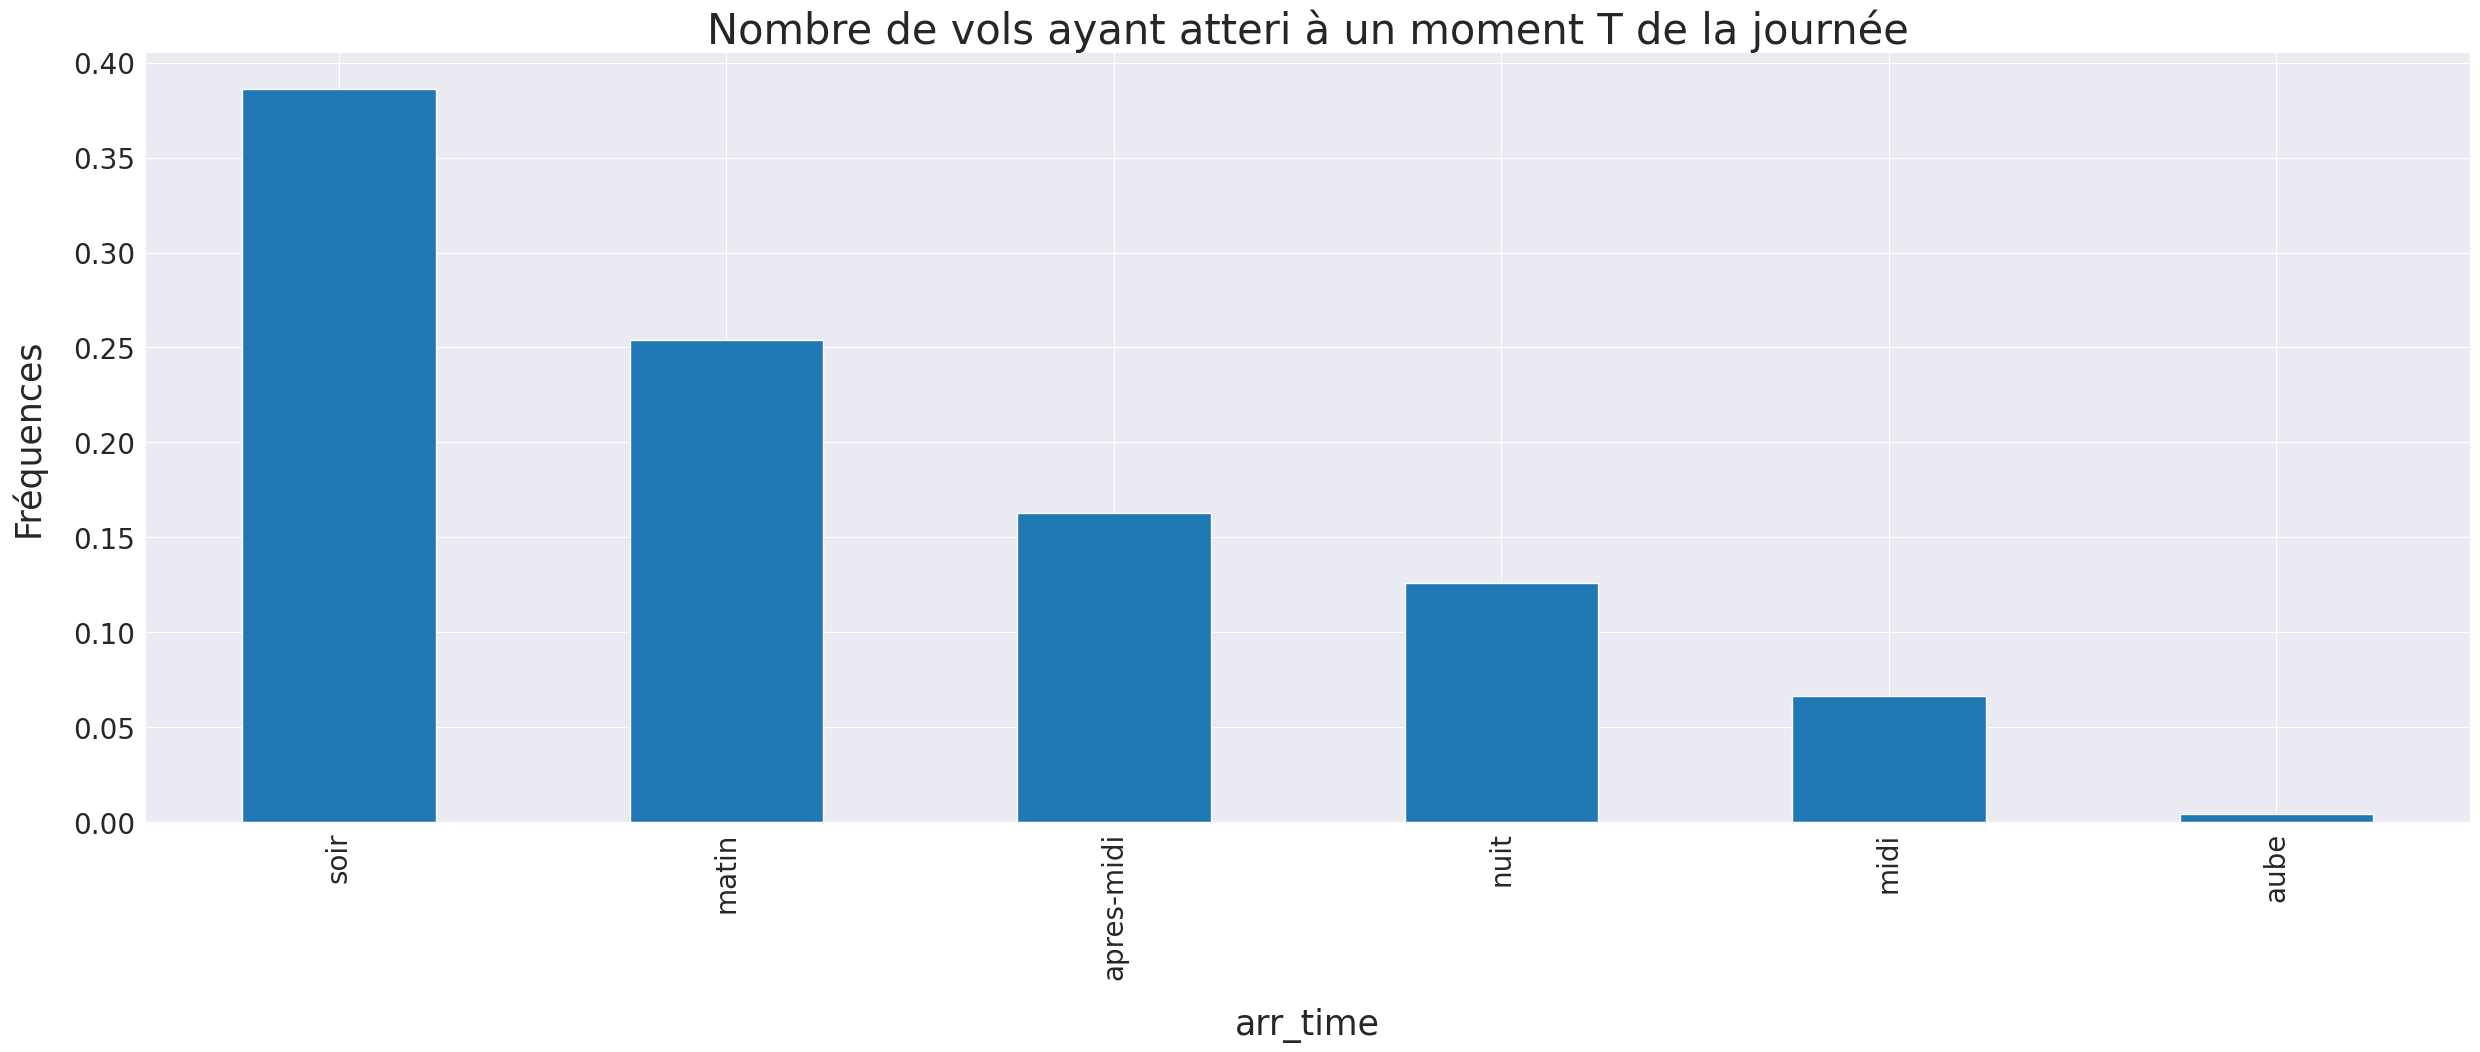

In [224]:
# Visualisation moment d'arrivée
plt.figure(figsize=(30, 10))
plt.title('Nombre de vols ayant atteri à un moment T de la journée', fontsize=30)
plt.xlabel("Moment de la journée", fontsize=25, labelpad=20); plt.ylabel("Fréquences", fontsize=25, labelpad=20)
plt.tick_params(labelsize=20)
data['arr_time'].value_counts(normalize=True).plot(kind='bar')
plt.show()

Quant à l'atterissage, c'est l'inverse. 1 vol sur 2 atterrit le soir et 1 vol sur 4 atterit le matin

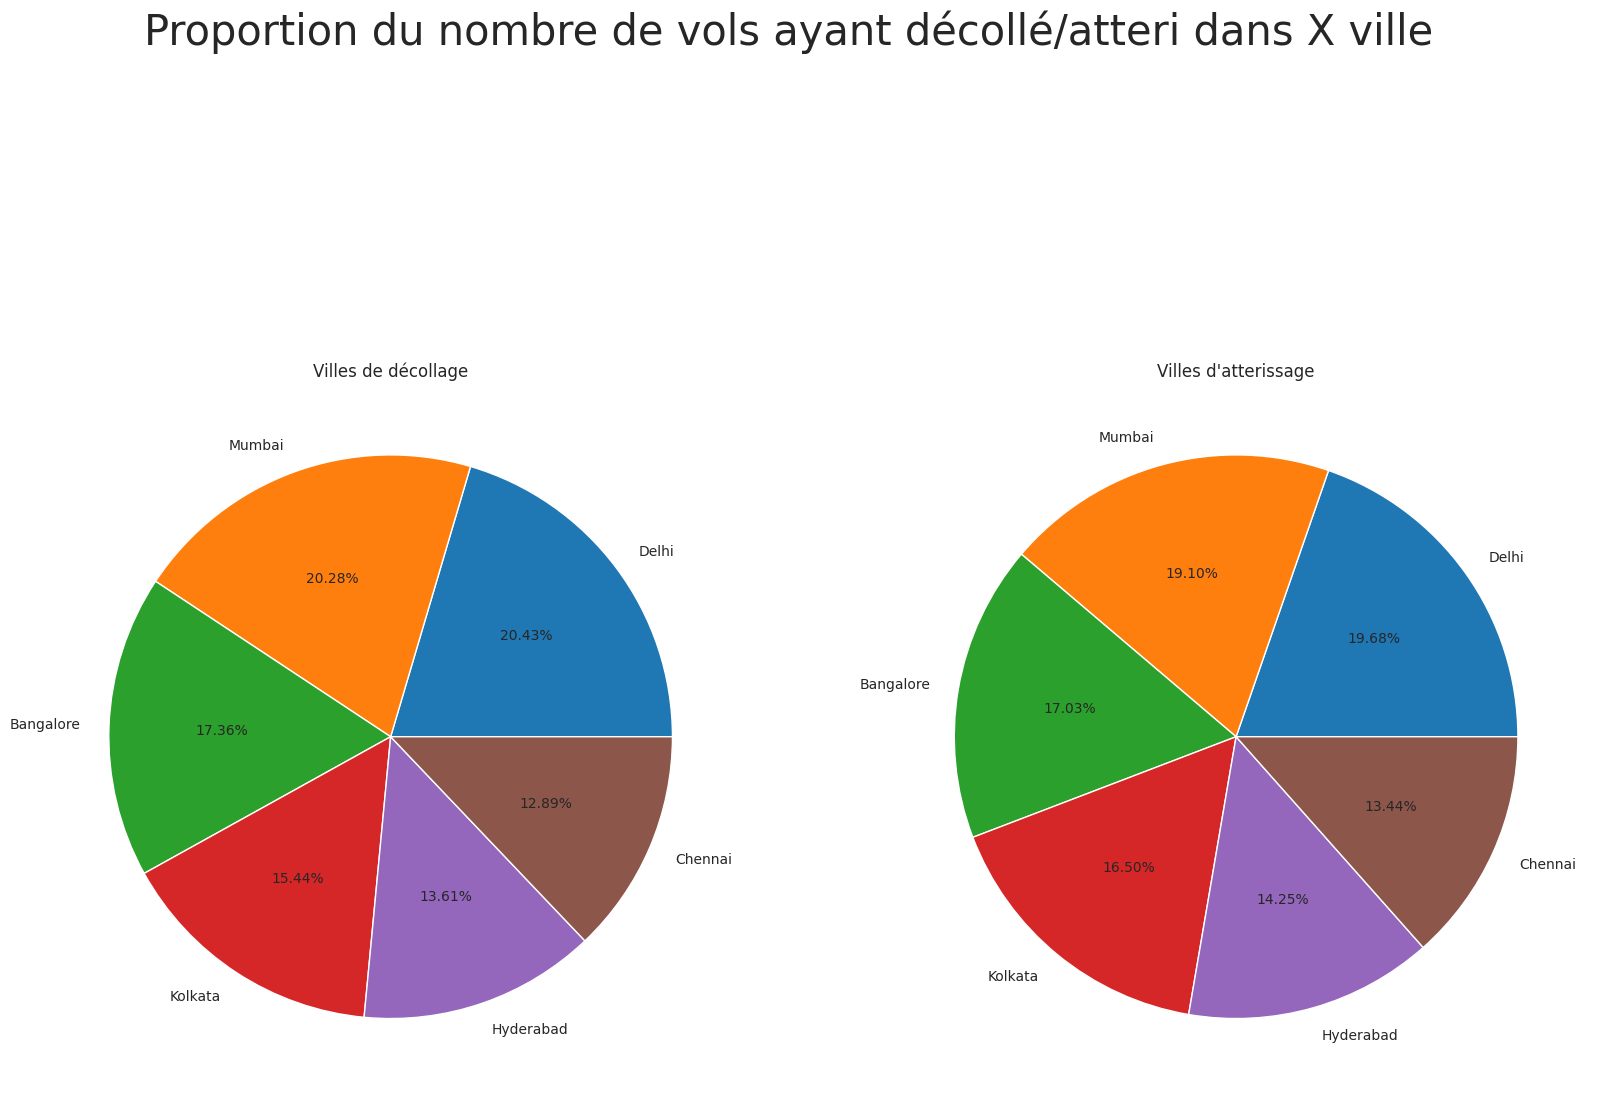

In [225]:
# visualisation des variables `from` et `to`
fig_one = data['from'].value_counts()
fig_two = data['to'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(20, 15))
fig.suptitle('Proportion du nombre de vols ayant décollé/atteri dans X ville', fontsize=30)
ax[0].set_title('Villes de décollage')
ax[0].pie(fig_one, autopct='%.2f%%', labels=fig_one.index)
ax[1].set_title('Villes d\'atterissage')
ax[1].pie(fig_two, autopct='%.2f%%', labels=fig_one.index)
plt.show()

À partir de ces graphes, on constate que la majorité des vols décollent et atterrissent principalement depuis les villes de Delhi et Mumbai.

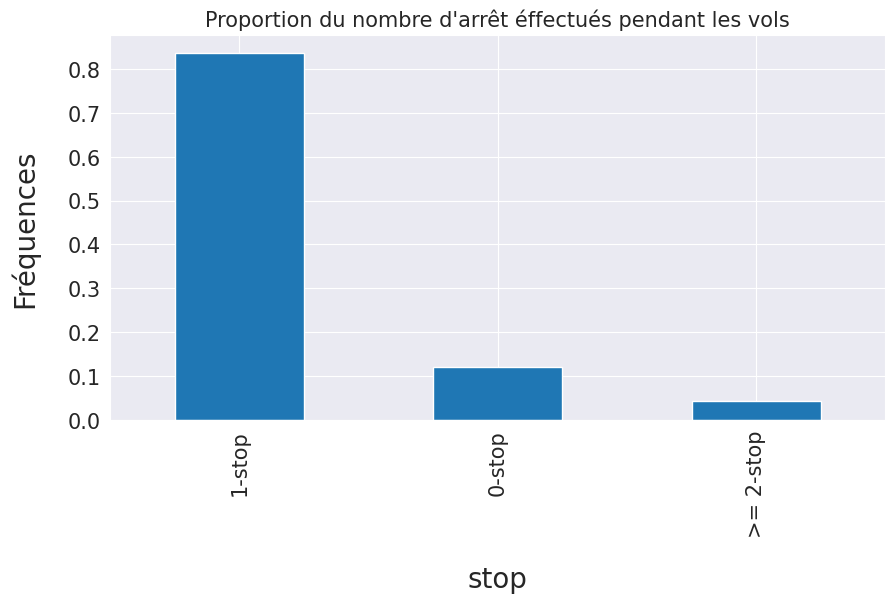

In [226]:
# Visualisation de la variable `stop`
plt.figure(figsize=(10, 5))
plt.title('Proportion du nombre d\'arrêt éffectués pendant les vols', fontsize=15)
plt.xlabel('Nombre d\'arrêt', fontsize=20, labelpad=20); plt.ylabel('Fréquences', fontsize=20, labelpad=20)
plt.tick_params(labelsize=15)

data['stop'].value_counts(normalize=True).plot(kind='bar')
plt.show()

La plupart des vols effectuent un arrêt avant d'arriver à destination, soit 4 vols sur 5.

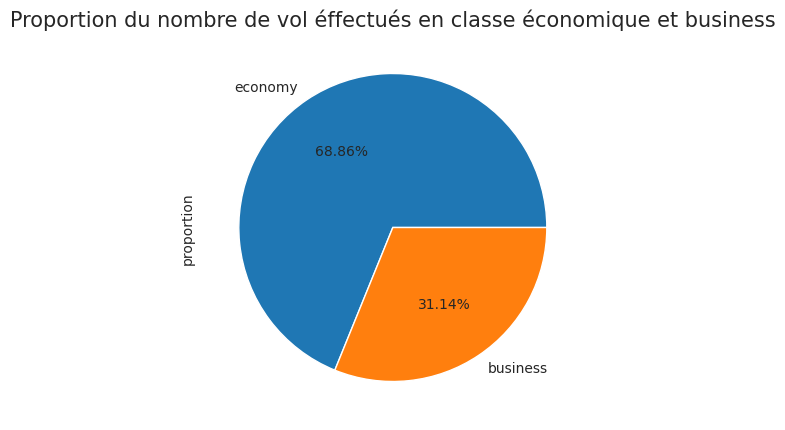

In [227]:
# Visualisation de la variable `class`
plt.figure(figsize=(10, 5))
plt.title('Proportion du nombre de vol éffectués en classe économique et business', fontsize=15)
data['class'].value_counts(normalize=True).plot(kind='pie', autopct='%.2f%%')
plt.show()

Notre échantillon de vols est en majorité de la classe économique.

In [228]:
# Variable `time_taken`
# On catégorise notre variable en intervalle de temps [court, moyen, long, très-long]
def categoriser_duree(duree):
    if timedelta(hours=0) <= duree < timedelta(hours=3):
        return 'court'
    elif timedelta(hours=3) <= duree < timedelta(hours=6):
        return 'moyen'
    elif timedelta(hours=6) <= duree < timedelta(hours=12):
        return 'long'
    else:
        return 'tres-long'

In [229]:
data['time_taken'] = data['time_taken'].apply(categoriser_duree)
data['time_taken'].head()

0        court
1        court
2    tres-long
3    tres-long
4         long
Name: time_taken, dtype: object

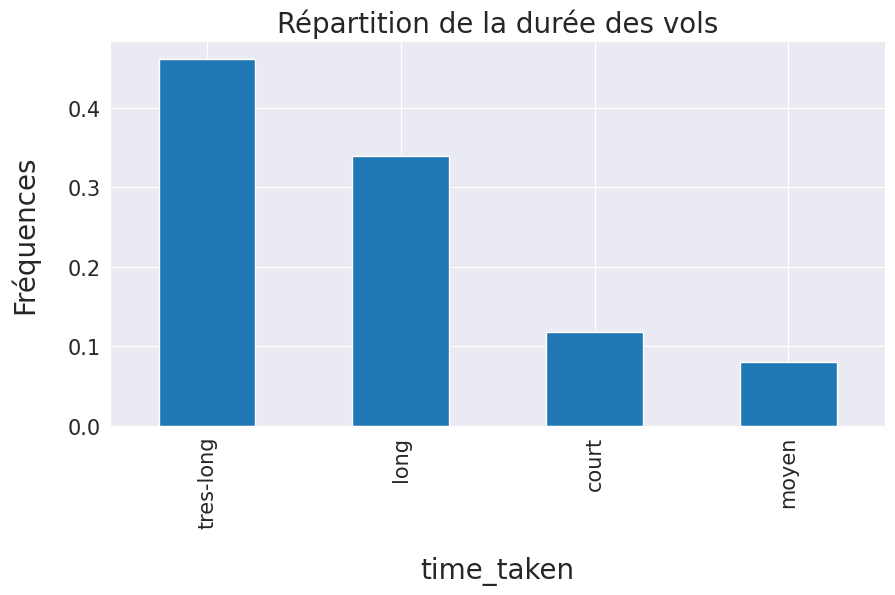

In [230]:
# Visualisation
plt.figure(figsize=(10, 5))
plt.title('Répartition de la durée des vols', fontsize=20)
plt.xlabel('Durée des vols', fontsize=20, labelpad=20); plt.ylabel('Fréquences', fontsize=20, labelpad=20)
plt.tick_params(labelsize=15)

data.time_taken.value_counts(normalize=True).plot(kind='bar')
plt.show()

Les vols de notre échantillon sont principalement des voyages très longs (+12 heures) et longs (entre 6 et 12 heures).

### Variables quantitatives

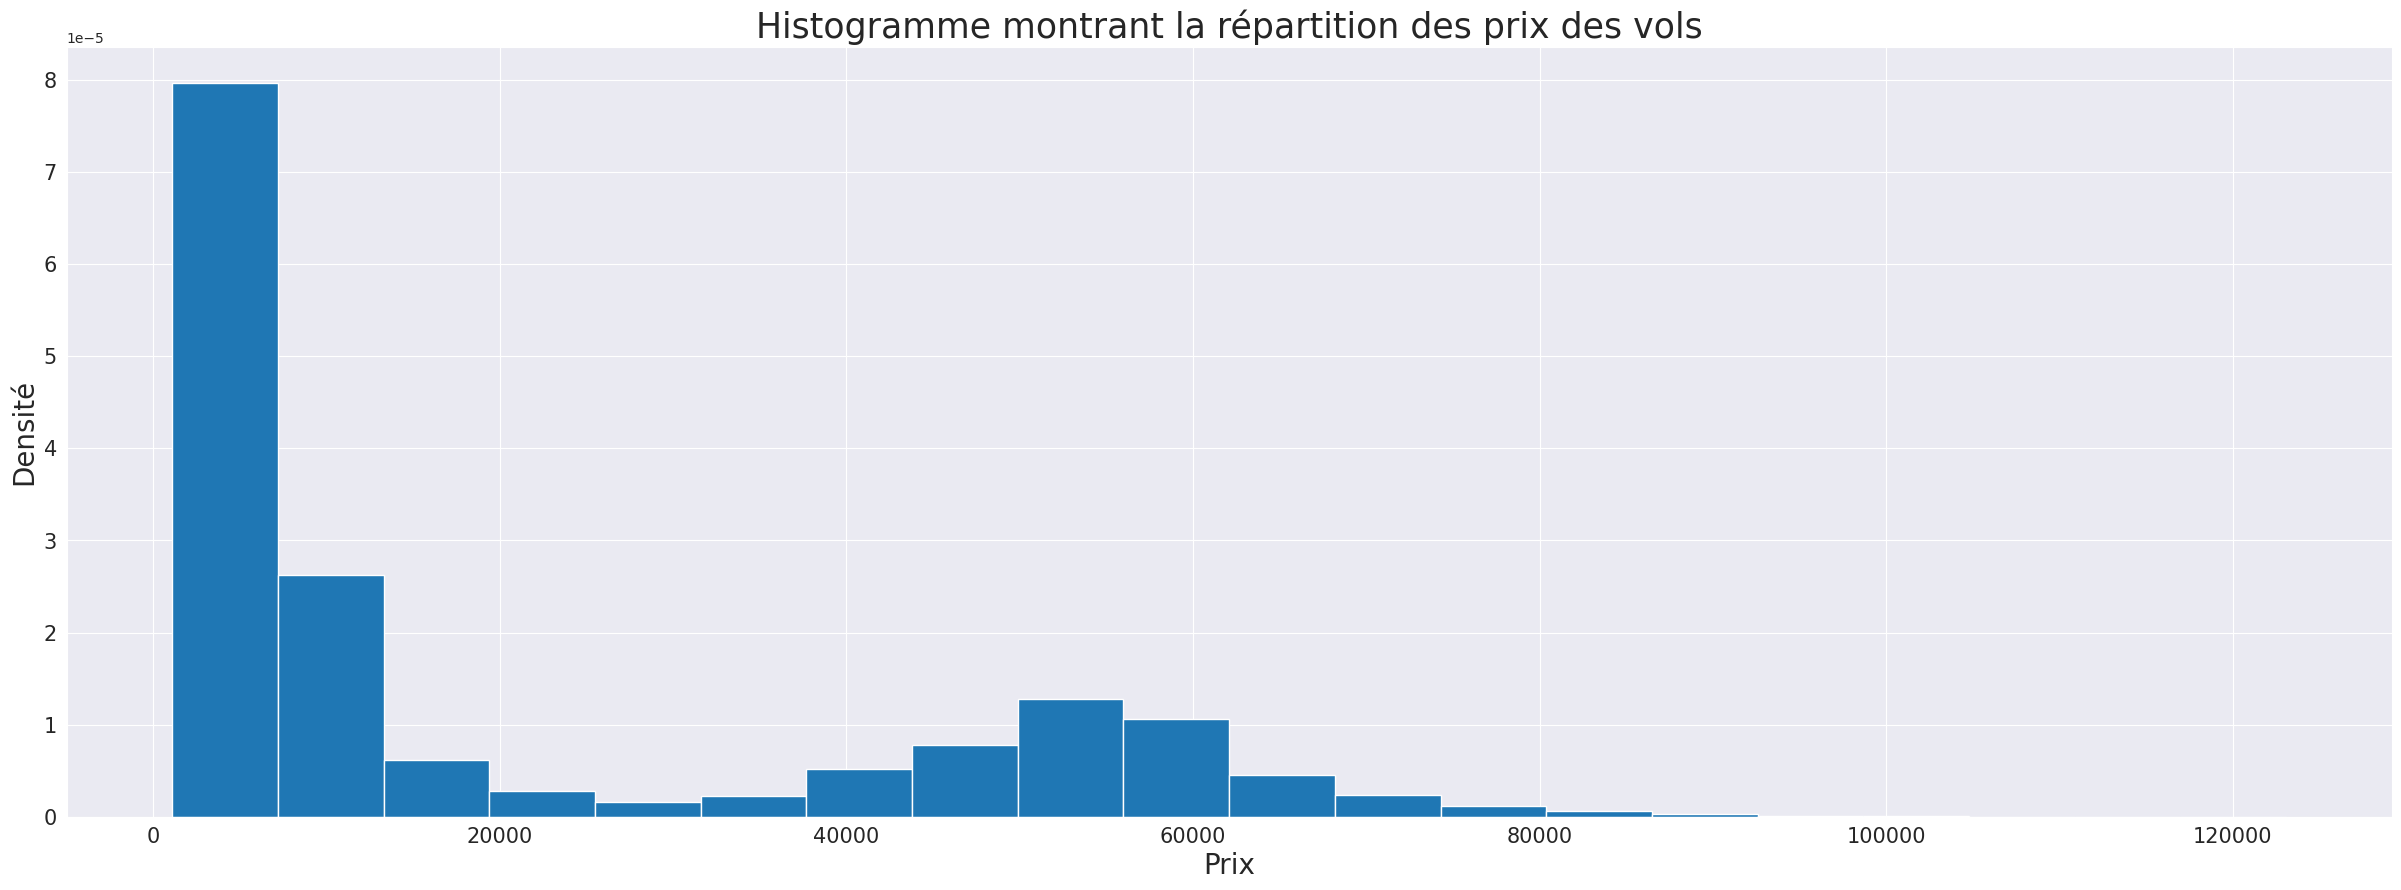

In [231]:
# prix des vols
plt.figure(figsize=(30, 10))
plt.title('Histogramme montrant la répartition des prix des vols', fontsize=25)
plt.xlabel('Prix', fontsize=20); plt.ylabel('Densité', fontsize=20)
plt.tick_params(labelsize=15)

plt.hist(data['price'], bins=20, density=True)
plt.show()

L'histogramme obtenu présente deux portions dont les distributions ont des allures différentes. Représentons chaque partie séparemment.

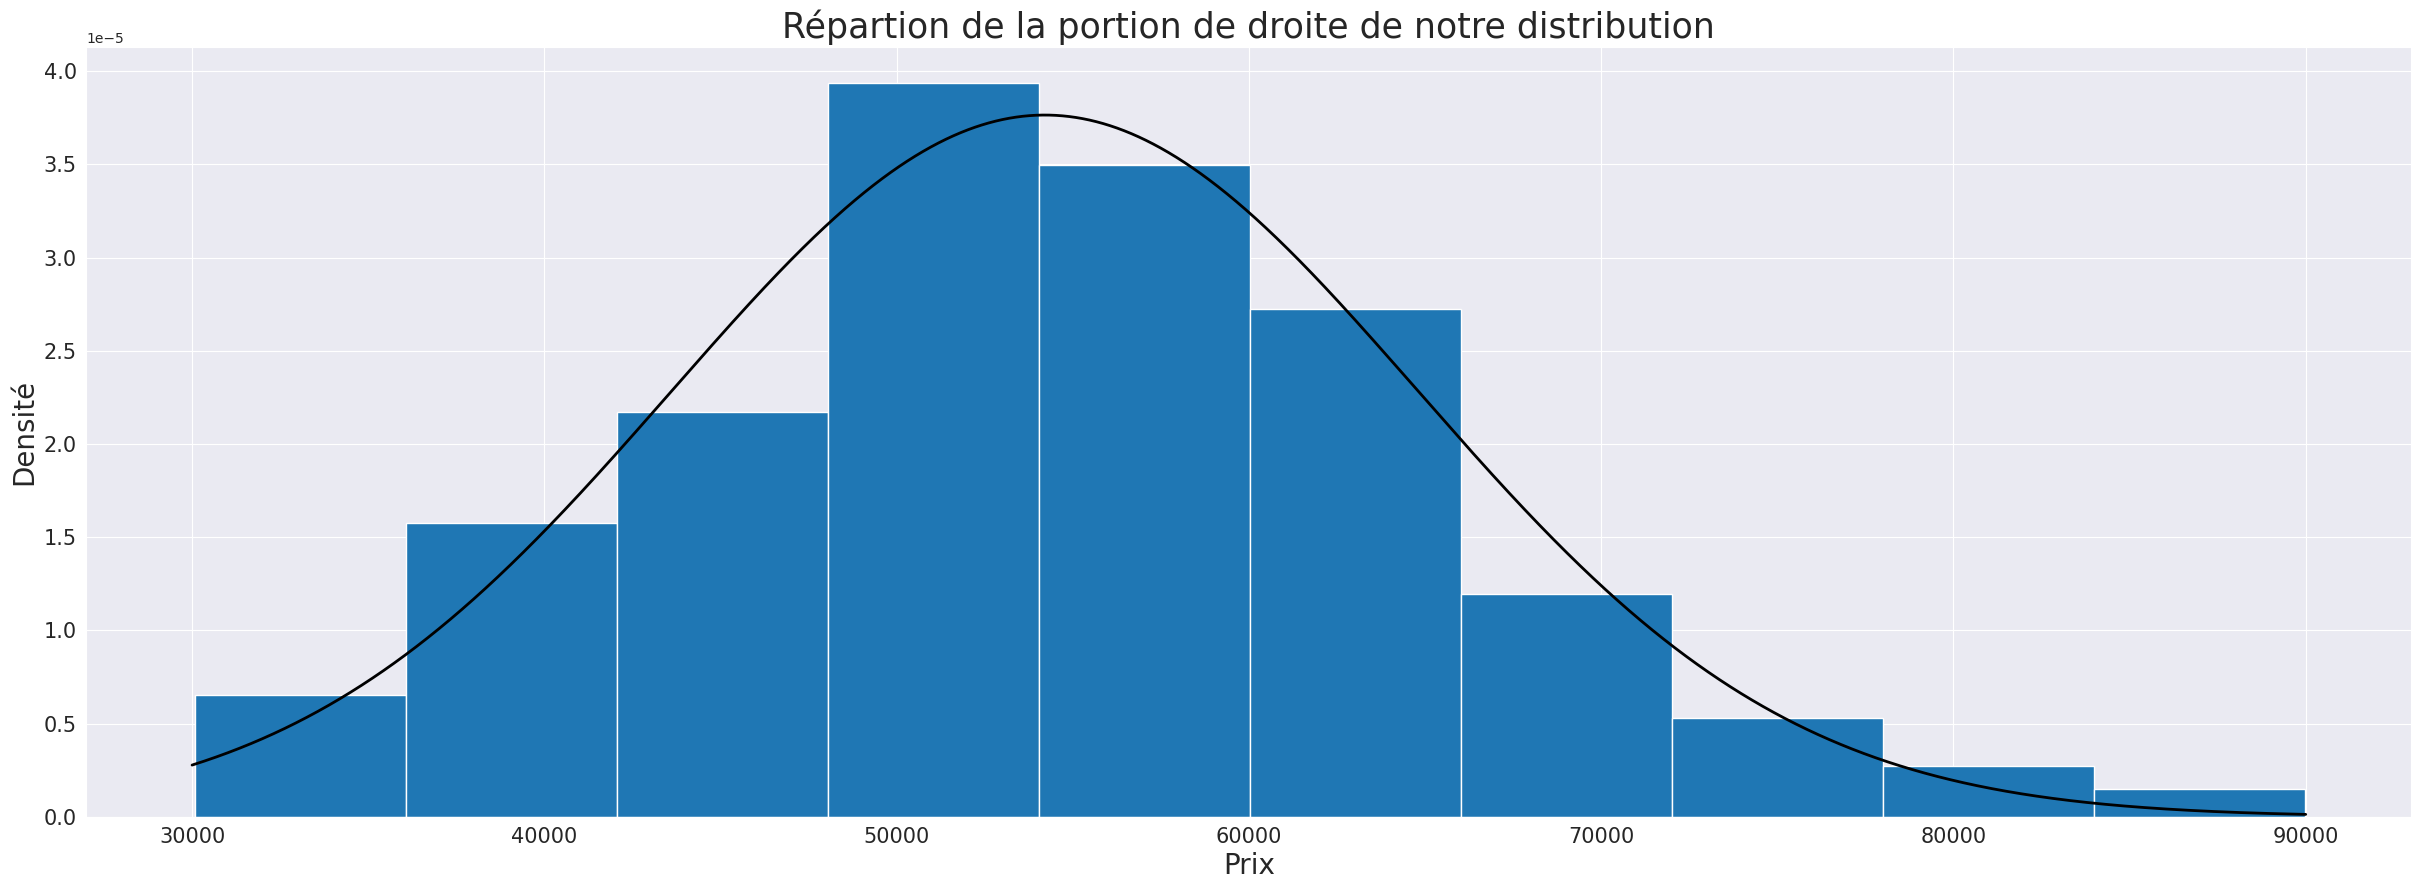

In [232]:
# portion de droite
xmin, xmax = 30000, 90000
mask = (data.price < xmax) & (data['price'] > xmin )
price = data.loc[mask, 'price']

mu, std = norm.fit(price)

plt.figure(figsize=(30, 10))
plt.title('Répartion de la portion de droite de notre distribution', fontsize=25)
plt.xlabel('Prix', fontsize=20); plt.ylabel('Densité', fontsize=20)
plt.tick_params(labelsize=15)

plt.hist(price, density=True)

x = np.linspace(xmin, xmax, price.count())
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.show()

Cette portion de notre distribution qui représente les vols en classe business, montre bien à travers son histogramme qu'elle semble suivre une loi normale.

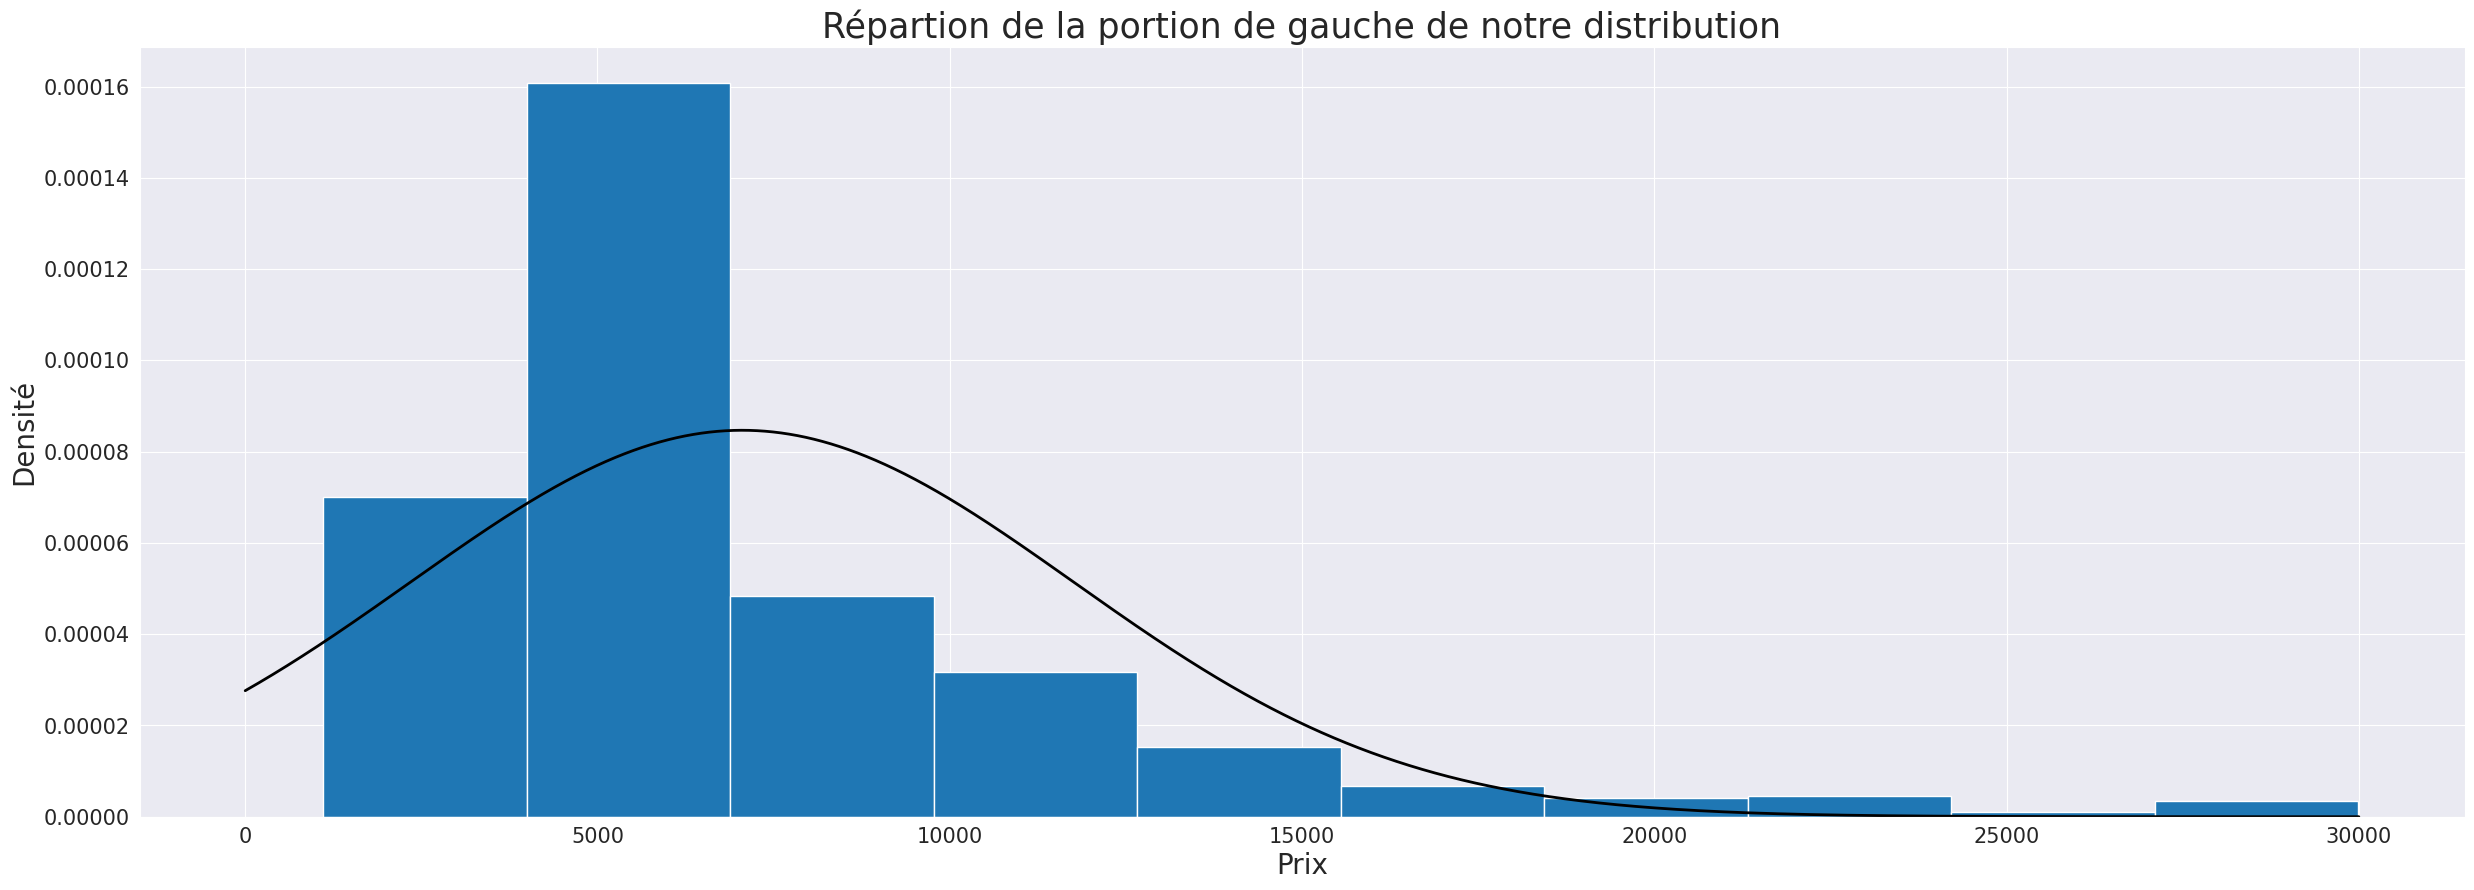

In [233]:
# prix des vols
xmin, xmax = 0, 30000
mask = (data.price < xmax) & (data['price'] > xmin )
price = data.loc[mask, 'price']

mu, std = norm.fit(price)

plt.figure(figsize=(30, 10))
plt.title('Répartion de la portion de gauche de notre distribution', fontsize=25)
plt.xlabel('Prix', fontsize=20); plt.ylabel('Densité', fontsize=20)
plt.tick_params(labelsize=15)

plt.hist(price, density=True)

x = np.linspace(xmin, xmax, price.count())
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.show()

Par contre, cette portion de la distribution qui représente les vols en classe economique, se rapproche moins d'une loi normale.

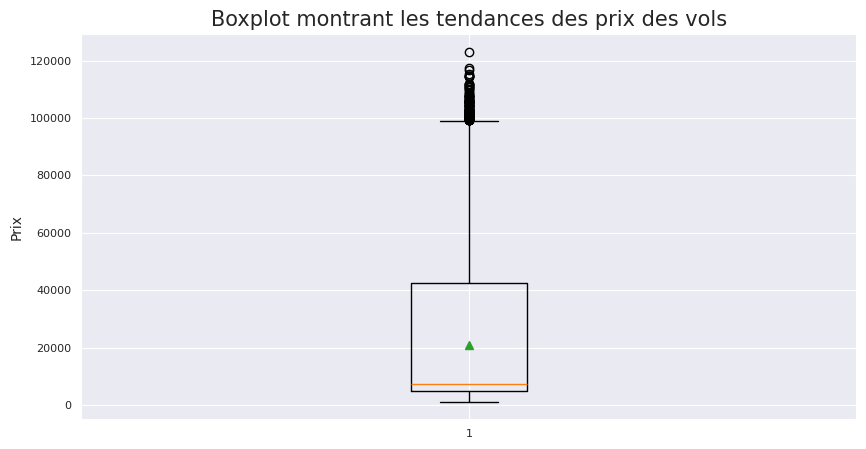

In [234]:
# Visualisation avec un boxplot
plt.figure(figsize=(10, 5))
plt.title('Boxplot montrant les tendances des prix des vols', fontsize=15)
plt.ylabel('Prix', fontsize=10)
plt.tick_params(labelsize=8)

plt.boxplot(data['price'], showmeans=True)
plt.show()

Notre distribution est plus centrée sur les prix allant de 2500 à 40000 dollars. De plus, on note la présence d'outliers montrant que le prix d'un vol ne monte au-dessus des 100000 dollars que de façon exceptionnelle.

In [235]:
# Mésures de tendance centrale, de dispersion
data['price'].describe()

count    300182.000000
mean      20888.070907
std       22697.260069
min        1105.000000
25%        4783.000000
50%        7425.000000
75%       42521.000000
max      123071.000000
Name: price, dtype: float64

La moyenne et l'écart-type nous indique une forte dispersion des prix autour du prix moyen "20888 dollars". De plus, la moitié des vols éffectués sont à moins de 7425 dollars.

Enfin, on étudiera la concentration, et l'applatissement de la distribution des deux portions de notre échantillon.

In [236]:
def mesures(minimum:int, maximum:int, alpha_:float):
    condition = (data.price < maximum) & (data.price > minimum )
    prix = data.loc[condition, 'price']
    print("Le skewness vaut: ", prix.skew().round(3))
    if 0 - alpha_ < prix.skew() < 0 + alpha_:
        print("Donc cette distribution est symétique et par conséquent on peut calculer le Kurtosis qui vaut:", prix.kurtosis().round(3))
        if 0 - alpha_ < prix.kurtosis() < 0 + alpha_:
            print("Donc cette distribution a le même applatissement qu'une distibution normale.")
        else:
            if prix.kurtosis() > 0:
                print("Le kurtosis étant positif, les observations sont moins concentrées.")
            else:
                print("Le kurtosis étant négatif, les observations sont plus concentrées.")
    else:
        print("Donc cette distribution est asymétrique.")
        if prix.skew() > 0:
            print("Elle s'étale vers la droite.")
        else:
            print("Elle s'étale vers la gauche.")


In [237]:
# Première portion
mesures(0, 30000, 0.05)

Le skewness vaut:  2.118
Donc cette distribution est asymétrique.
Elle s'étale vers la droite.


In [238]:
# Deuxième portion
mesures(30000, 80000, 0.05)

Le skewness vaut:  0.017
Donc cette distribution est symétique et par conséquent on peut calculer le Kurtosis qui vaut: -0.224
Le kurtosis étant négatif, les observations sont plus concentrées.


## Analyse Bivariée

Avant de se lancer dans cette étape, commençons par exposer les questions auquelles nous devrons répondre.
- Y a-t-il une période où une compagnie aérienne compte plus de vols que d'autres ?
- Quel moment de la journéee est priviligié dans une période X donnée pour le départ d'un vol ?
- Quel sont les destinations les plus fréquentées dans une période X donnée ?
- Le prix d'un vol est-il influencé par la période pendant laquelle le vol sera effectué ?
- Est-ce-que certaines compagnies aériennes priviligient un moment de la journée pour le départ de leurs vols ?
- Quels sont les villes de départ et les destinations principales d'une compagnie aérienne X ?
- Quelle est la durée de voyage la plus fréquente de chaque compagnie aérienne ?
- Quelles sont les compagnies aériennes qui font en moyenne le plus d'escale ?
- Pour la classe business puis la classe économique, quelle est le prix moyen des vols ?
- Une compagnie aérienne a-t-elle des prix de vols plus chers qu'une autre ?
- Les vols ont-ils tendances à démarrer à un moment T de la journée en fonction de la ville de départ ?
- Les villes de départ et d'arrivée influencent-elles le prix du billet de vol ?
- Existe-t-il un lien entre la durée du trajet et le prix du vol ?
- Le nombre d'escales influence-t-il le prix du vol ?

***Y a-t-il une période où une compagnie aérienne compte plus de vols que d'autres ?***

In [239]:
def show_pivot_table(variable):
    # Pour commencer, on va regrouper les vols
    grouped_by_ = data.groupby([data.date.dt.to_period('W'), variable]).agg(count=(variable, 'count')).reset_index()
    # On visualise tout ça avec un tableau croisé
    pivot_by_ = grouped_by_.pivot_table(index='date', columns=variable, values='count')
    pivot_by_ = (pivot_by_.div(pivot_by_.sum(axis=1), axis=0) * 100).round(3)
    return pivot_by_

In [240]:
pivot_by_airline = show_pivot_table("airline")
pivot_by_airline

airline,Air India,AirAsia,GO FIRST,Indigo,SpiceJet,StarAir,Trujet,Vistara
date,,,,,,,,
2022-02-07/2022-02-13,34.398,3.400,3.801,16.498,3.772,0.029,0.039,38.062
2022-02-14/2022-02-20,28.854,3.127,3.842,14.070,3.765,0.015,0.010,46.317
2022-02-21/2022-02-27,26.041,5.838,8.973,13.440,3.449,0.020,0.013,42.226
2022-02-28/2022-03-06,26.557,5.671,8.796,14.228,2.875,0.020,0.013,41.840
2022-03-07/2022-03-13,26.511,5.708,8.729,14.321,2.774,0.020,0.015,41.923
2022-03-14/2022-03-20,26.660,5.752,8.392,14.296,2.781,0.020,0.015,42.084
2022-03-21/2022-03-27,26.839,5.706,8.199,14.578,2.665,0.022,0.015,41.976
2022-03-28/2022-04-03,24.710,6.163,7.150,15.678,2.337,0.025,NaN,43.937


Quelle que soit la période (semaine), la compagnie aérienne Vistara
compte systématiquement plus de vols que toutes les autres compagnies.

Cela indique que :
1. Vistara domine le marché de manière constante
2. Les préférences des voyageurs sont stables dans le temps
3. Il n'y a pas de variation saisonnière dans le choix de compagnie

→ Conclusion : Les voyageurs montrent une préférence marquée et
constante pour Vistara, indépendamment de la période.

***Quel moment de la journéee est priviligié dans une période X donnée pour le départ d'un vol ?***

In [241]:
pivot_by_deptime = show_pivot_table("dep_time")
pivot_by_deptime

dep_time,apres-midi,aube,matin,midi,nuit,soir
date,,,,,,
2022-02-07/2022-02-13,19.526,2.018,41.305,8.210,0.509,28.431
2022-02-14/2022-02-20,16.888,3.040,43.573,8.574,0.625,27.300
2022-02-21/2022-02-27,17.674,3.815,41.766,8.674,1.081,26.990
2022-02-28/2022-03-06,17.730,3.641,42.082,8.620,1.222,26.704
2022-03-07/2022-03-13,17.804,3.587,42.173,8.724,1.234,26.478
2022-03-14/2022-03-20,17.757,3.554,42.146,8.687,1.218,26.638
2022-03-21/2022-03-27,17.919,3.753,41.842,8.649,1.287,26.550
2022-03-28/2022-04-03,18.682,4.023,41.764,7.841,1.551,26.139


L'analyse révèle une préférence marquée et constante pour les vols du matin :
- Quelle que soit la période, les départs en matinée représentent
  le plus grand nombre de vols.
- Cette préférence est stable dans le temps (toutes les semaines).
- Les voyageurs privilégient clairement les départs en matinée.

→ Conclusion : Les voyageurs montrent une préférence forte et
constante pour les vols du matin, indépendamment de la période.

***Quel sont les destinations les plus fréquentées dans une période X donnée ?***

In [242]:
pivot_by_destination = show_pivot_table("to")
pivot_by_destination

to,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
date,,,,,,
2022-02-07/2022-02-13,17.047,13.745,16.998,15.097,17.233,19.879
2022-02-14/2022-02-20,17.069,13.263,18.889,14.501,16.628,19.650
2022-02-21/2022-02-27,16.925,13.151,19.125,13.983,16.829,19.988
2022-02-28/2022-03-06,17.024,13.582,19.124,13.975,16.528,19.767
2022-03-07/2022-03-13,16.991,13.679,19.256,14.112,16.192,19.770
2022-03-14/2022-03-20,16.953,13.667,19.194,14.360,16.073,19.754
2022-03-21/2022-03-27,16.965,13.575,19.107,14.313,16.566,19.475
2022-03-28/2022-04-03,17.446,12.797,19.791,14.406,16.558,19.001


Encore le même constat pour la destination des vols :
L'analyse révèle en effet une préférence marquée et constante pour les vols à destination de Mumbai :
- Quelle que soit la période, cette destination de vol représentent
  le plus grand nombre de vols.
- Cette préférence est stable dans le temps (toutes les semaines).
- Les voyageurs privilégient clairement les voyages pour Mumbai.

→ Conclusion : Les voyageurs montrent une préférence forte et
constante pour les vols à destination de Mumbai, indépendamment de la période.

***Le prix d'un vol est-il influencé par la période pendant laquelle le vol sera effectué ?***

Pour simplifier la problématique, voici ce qu'il faut savoir. Pour deux vols ayant les mêmes caractéristiques, c'est-à-dire, même compagnie aérienne, même moment de départ, même nombre d'arrêts, etc, si le prix varie d'une période à l'autre, alors là, on pourrait déduire que la période influence le prix.

In [243]:
# On regroupe les vols par ces caractéristiques puis on vérifie si le nombre d'observations est suffisante
min_obs = 3
grouped_by_all = data.groupby(['airline', 'dep_time', 'from', 'time_taken', 'stop', 'arr_time', 'to', 'class']).filter(lambda count_row: len(count_row) >= min_obs)

# On calcule les mésures pour la variation des prix selon chaque groupe.
variations_price = grouped_by_all.groupby(['airline', 'dep_time', 'from', 'time_taken', 'stop', 'arr_time', 'to', 'class'])['price'].agg(['std', 'mean'])

# On vérifie si la variation est inférieur au seuil de 10%.
variations_price['variations'] = variations_price['std'] / variations_price['mean']
result = variations_price['variations'] <= 0.1
result.value_counts()

variations
False    3608
True     1312
Name: count, dtype: int64

L'analyse révèle que la période influence les prix de manière TRÈS significative :
- Dans 73% des cas, les prix varient de plus de 10% selon la période
- Seulement 27% des groupes de vols montrent une stabilité des prix
- Cela signifie que pour près de 3 vols sur 4, le moment de réservation
  peut entraîner des différences de prix substantielles.

→ Conclusion : La période influence FORTEMENT les prix des vols,
ce qui confirme l'importance du timing dans la réservation de vols.

***Est-ce-que certaines compagnies aériennes priviligient un moment de la journée pour le départ de leurs vols ?***

In [244]:
# Pour ça on va juste voir le nombre de vols éffectués par chaque compagnie en fonction du moment de la journée
pivot_airline_by_deptime = data.pivot_table(index='airline', columns='dep_time', values="date", aggfunc='count').reset_index()
melt_airline_by_deptime = pivot_airline_by_deptime.melt(id_vars="airline", value_name="nombre_de_vols", var_name="moment_de_depart")
melt_airline_by_deptime.head()

,airline,moment_de_depart,nombre_de_vols
0,Air India,apres-midi,14945.0
1,AirAsia,apres-midi,3016.0
2,GO FIRST,apres-midi,5328.0
3,Indigo,apres-midi,9720.0
4,SpiceJet,apres-midi,1392.0


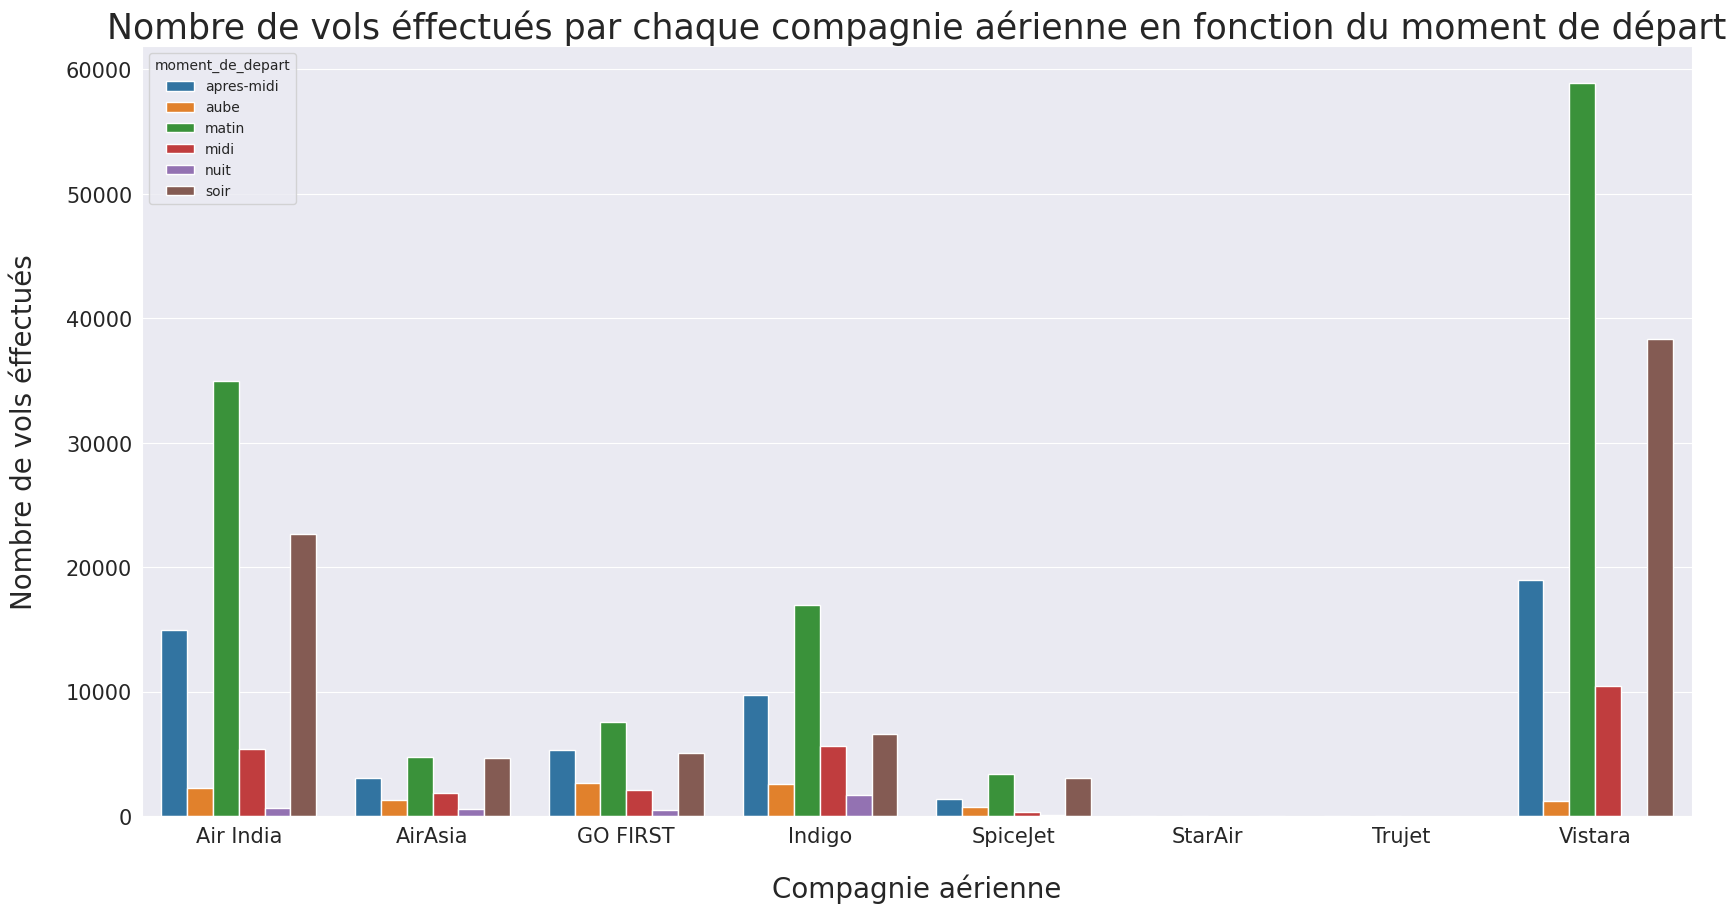

In [245]:
# Ce n'est pas bien clair alors, on visualise avec un diagramme en bâton
plt.figure(figsize=(20, 10))
plt.title('Nombre de vols éffectués par chaque compagnie aérienne en fonction du moment de départ', fontsize='25')
plt.xlabel('Compagnie aérienne', fontsize=20, labelpad=20); plt.ylabel('Nombre de vols éffectués', fontsize=20, labelpad=20)
plt.tick_params(labelsize=15)

sns.barplot(melt_airline_by_deptime, x='airline', y='nombre_de_vols', hue='moment_de_depart', palette='tab10')
plt.show()

La visualisation nous montre bien que la majorité des compagnies aériennes (si ce n'est toutes), démarrent leurs vols majoritairement le matin.

→ Conclusion : Les compagnies aériennes semblent bien privilégier un moment de la journée en particulier (la matinée) pour démarrer leurs vols.

***Quels sont les villes de départ et les destinations principales d'une compagnie aérienne X ?***

On va diviser cette problématique en deux :
- nous allons d'abord gérer les villes de départ
- puis terminer sur les villes de destination

In [246]:
# On regroupe d'abord le nombre de vols pour chaque compagnie aérienne pour chaque ville de départ à l'aide d'un tableau croisé.
pivot_airline_by_from = data.pivot_table(index="airline", columns="from", values="date", aggfunc="count").reset_index()

# Puis, on va transformer notre tableau croisé en tableau unilatéral pour la visualisation
melt_airline_by_from = pivot_airline_by_from.melt(id_vars="airline", var_name="ville_de_depart", value_name="nombre_de_vols")
melt_airline_by_from.head()


,airline,ville_de_depart,nombre_de_vols
0,Air India,Bangalore,12052.0
1,AirAsia,Bangalore,3360.0
2,GO FIRST,Bangalore,4498.0
3,Indigo,Bangalore,7080.0
4,SpiceJet,Bangalore,1255.0


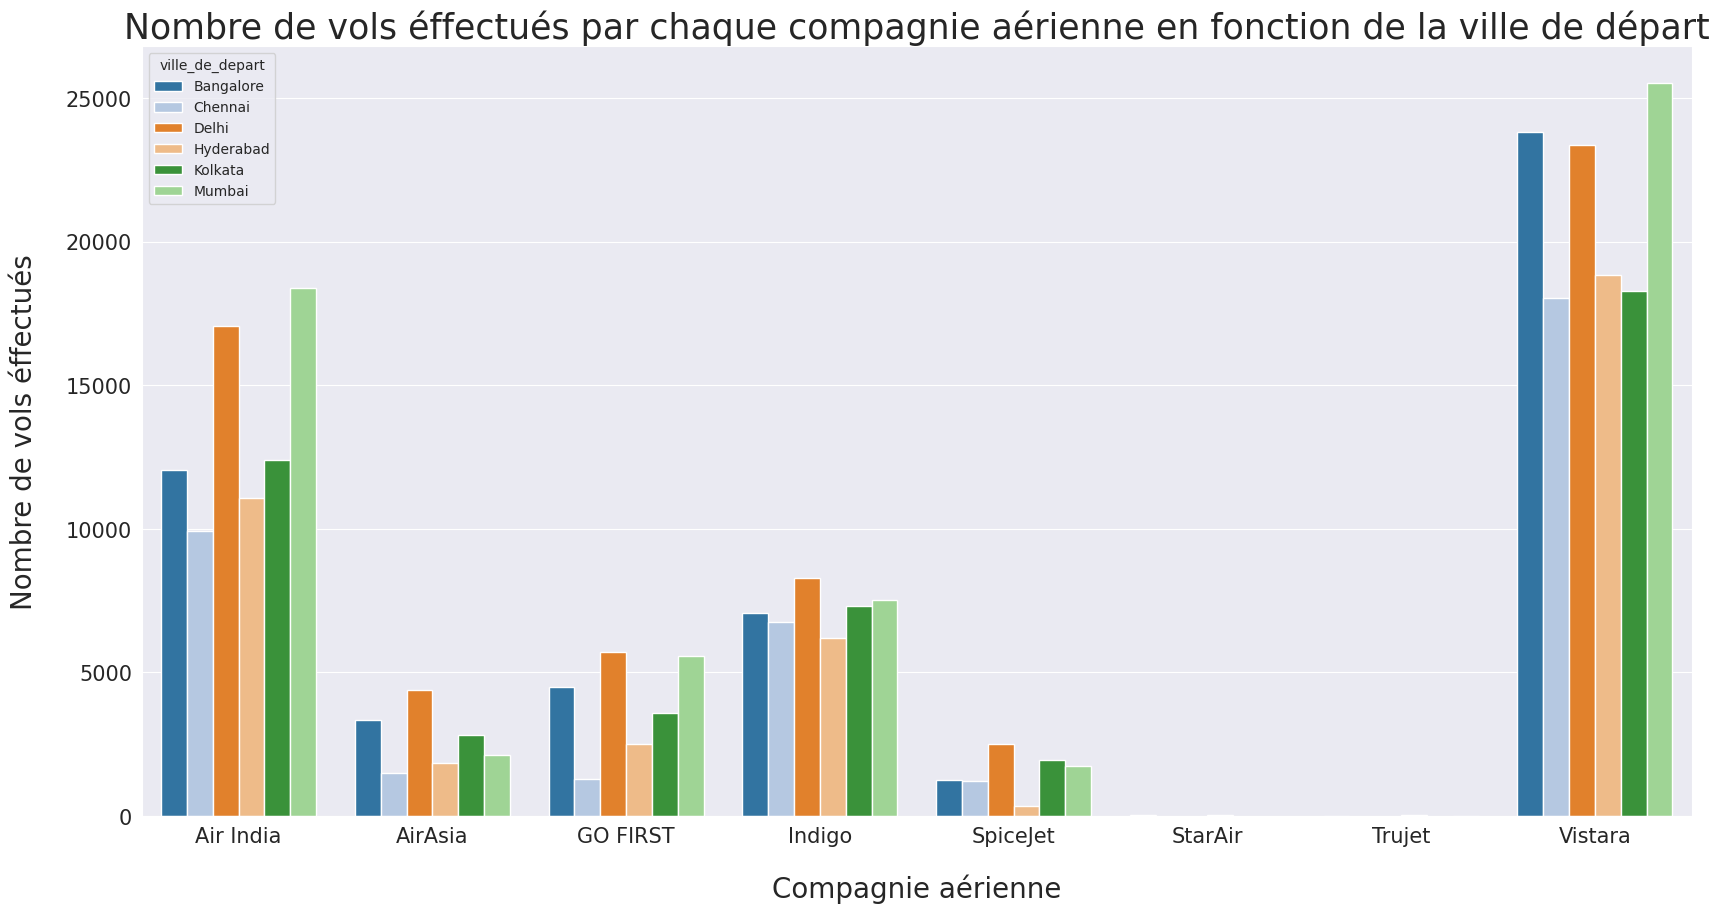

In [247]:
# On visualise avec un diagramme en bâton
plt.figure(figsize=(20, 10))
plt.title('Nombre de vols éffectués par chaque compagnie aérienne en fonction de la ville de départ', fontsize='25')
plt.xlabel('Compagnie aérienne', fontsize=20, labelpad=20); plt.ylabel('Nombre de vols éffectués', fontsize=20, labelpad=20)
plt.tick_params(labelsize=15)

sns.barplot(melt_airline_by_from, x='airline', y='nombre_de_vols', hue='ville_de_depart', palette='tab20')
plt.show()

Notre visualisation relève deux points :
- Les compagnies aériennes telles qu'Air India et Visatara, démarrent principalement leurs vols depuis la ville de Mumbai
- Quant aux compagnies Air Asia, Go First, Indigo et SpiceJet, eux démarrent plutôt leurs vols depuis Dehli.

Sinon en général les villes de Mumbai, Delhi et en troixième Bangalore sont les principales villes de départ de vols, toutes compagnies aériennes confondues.

→ Conclusion : Les compagnies aériennes auront plus intérêt à investir dans ces villes pour attirer le plus de voyageurs possibles.

On utilise le même processus pour obtenir notre analyse sur les villes de destination

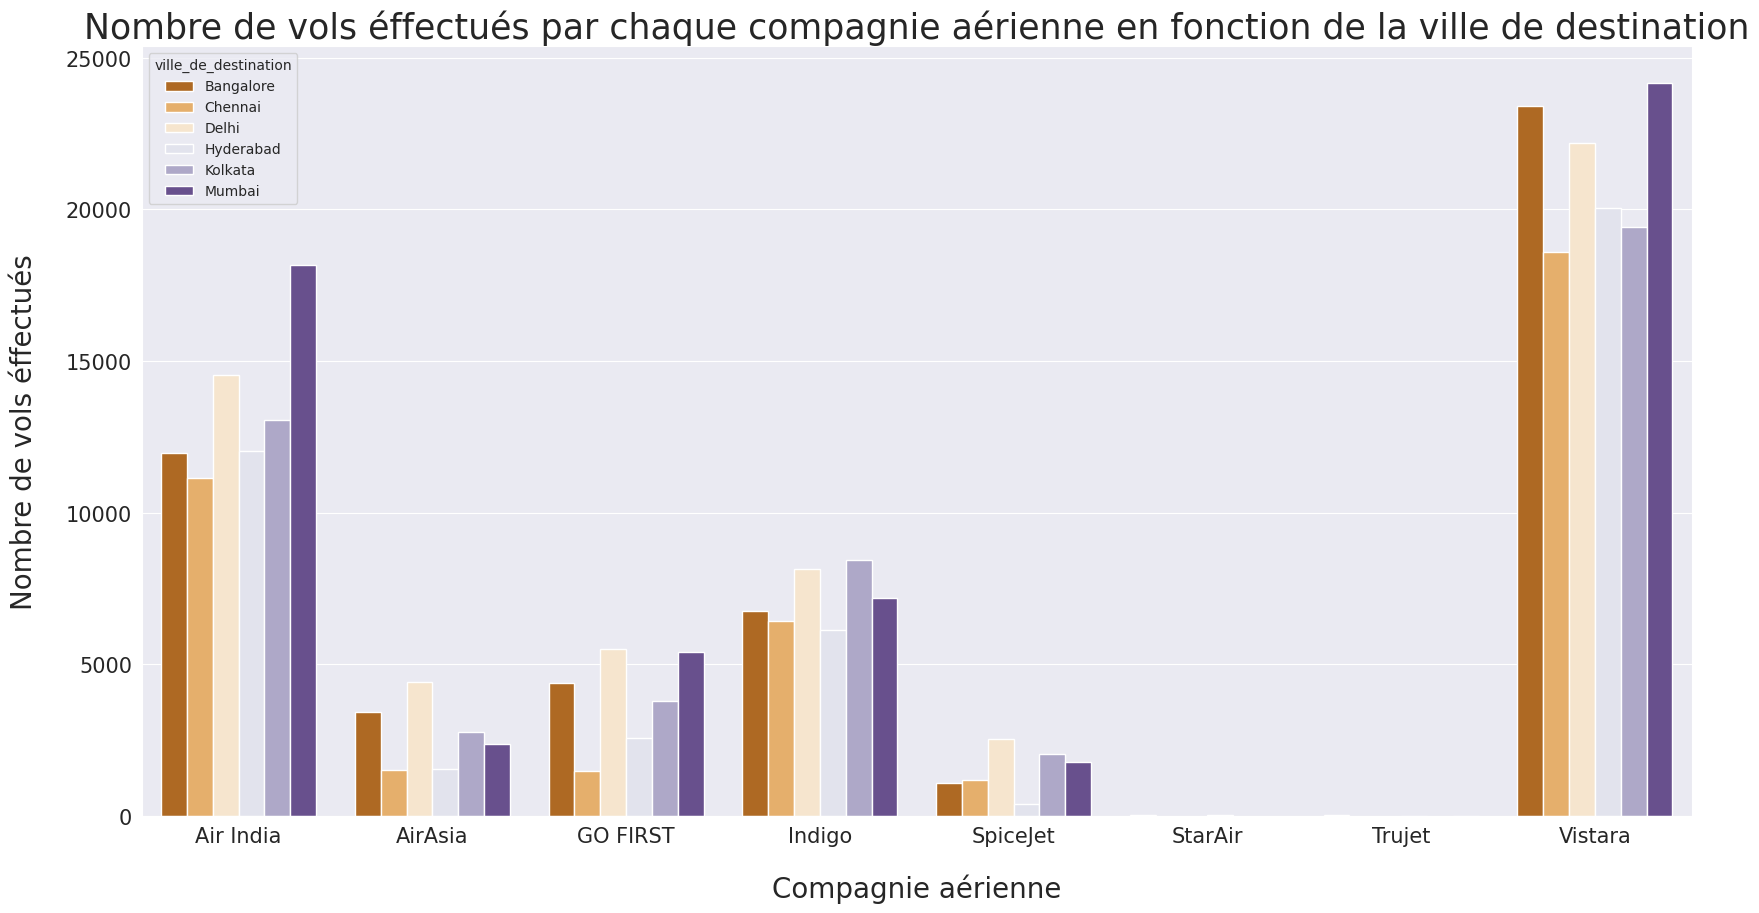

In [248]:
# On regroupe d'abord le nombre de vols pour chaque compagnie aérienne pour chaque ville de destination à l'aide d'un tableau croisé.
pivot_airline_by_to = data.pivot_table(index="airline", columns="to", values="date", aggfunc="count").reset_index()

# Puis, on va transformer notre tableau croisé en tableau unilatéral pour la visualisation
melt_airline_by_to = pivot_airline_by_to.melt(id_vars="airline", var_name="ville_de_destination", value_name="nombre_de_vols")
# On visualise avec un diagramme en bâton
plt.figure(figsize=(20, 10))
plt.title('Nombre de vols éffectués par chaque compagnie aérienne en fonction de la ville de destination', fontsize='25')
plt.xlabel('Compagnie aérienne', fontsize=20, labelpad=20); plt.ylabel('Nombre de vols éffectués', fontsize=20, labelpad=20)
plt.tick_params(labelsize=15)

sns.barplot(melt_airline_by_to, x='airline', y='nombre_de_vols', hue='ville_de_destination', palette='PuOr')
plt.show()

De cette analyse, on fait le même constat. Les villes de Mumbai, Delhi et Bangalore sont les principales destinations des voyageurs.

***Quelle est la durée de voyage la plus fréquente de chaque compagnie aérienne ?***

In [249]:
pivot_airline_by_tt = data.pivot_table(index='airline', columns='time_taken', values='date', aggfunc='count').fillna(0).reset_index()
pivot_airline_by_tt

time_taken,airline,court,long,moyen,tres-long
0,Air India,6278.0,17279.0,2844.0,54491.0
1,AirAsia,2433.0,8080.0,1599.0,3947.0
2,GO FIRST,3223.0,12211.0,2491.0,5220.0
3,Indigo,10878.0,21660.0,10343.0,233.0
4,SpiceJet,2442.0,1307.0,706.0,4556.0
5,StarAir,40.0,0.0,21.0,0.0
6,Trujet,26.0,7.0,8.0,0.0
7,Vistara,10260.0,41411.0,6206.0,69982.0


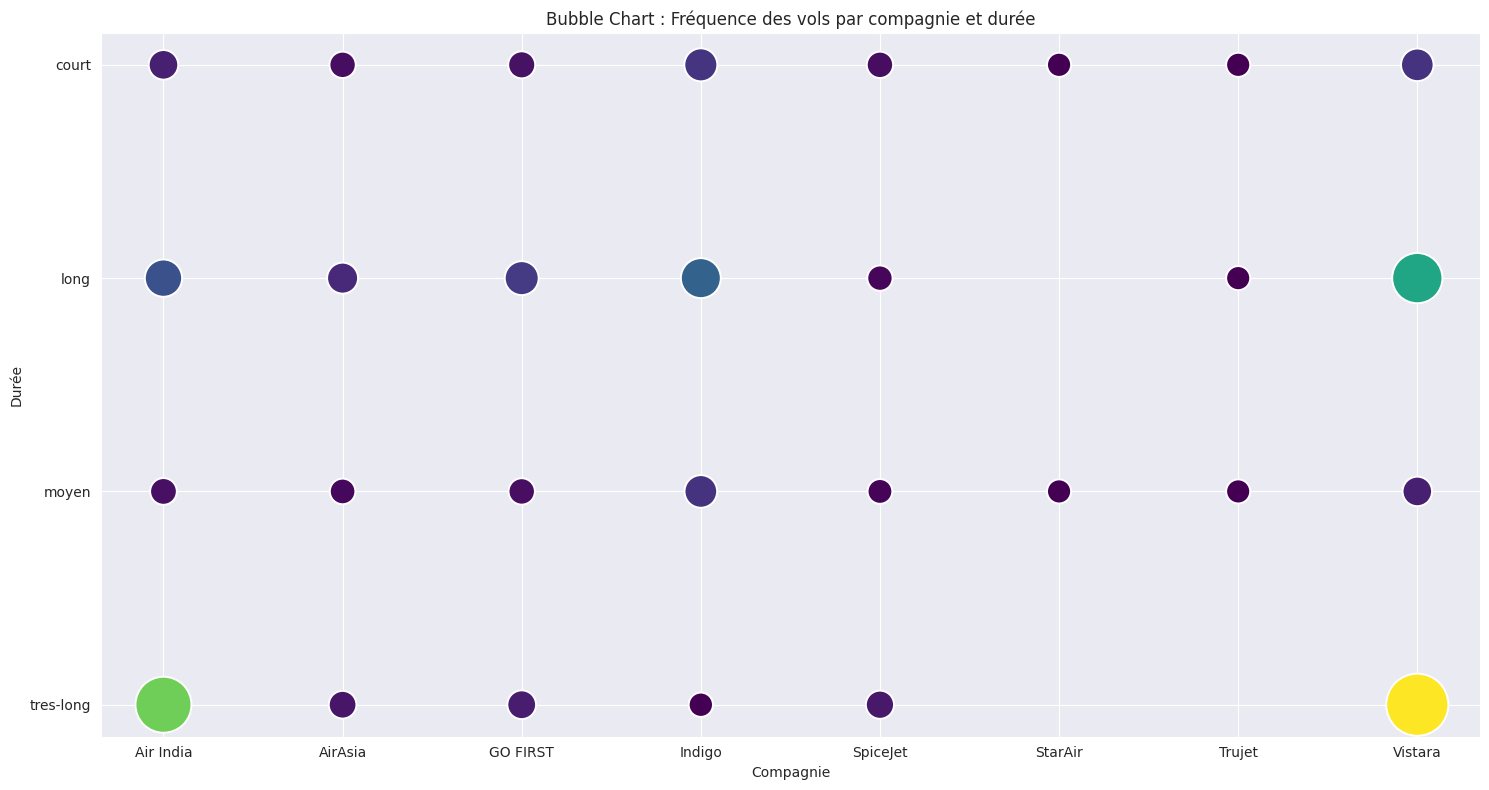

In [250]:
# Visualisation
freq = data.groupby(['airline', 'time_taken']).size().reset_index(name='count')
plt.figure(figsize=(15, 8))
sns.scatterplot(data=freq, x='airline', y='time_taken', size='count', hue='count', palette='viridis', sizes=(300, 2000), legend=False)

plt.title("Bubble Chart : Fréquence des vols par compagnie et durée")
plt.xlabel("Compagnie")
plt.ylabel("Durée")
plt.grid(True)
plt.tight_layout()
plt.show()

Ce qu'on peut remarquer :
- Les compagnies aériennes Air India et Vistara éffectuent majoritairement des très longs voyages.
- Les compagnies aériennes Go First et Indigo et Air Asia quant à eux ne font en majorité que des longs trajets.
- Enfin, on peut remarquer que les compagnies StarAir et Trujet, eux ne font pratiquement pas de trajets très longs, mais privilégient les courts et moyens trajets.

→ Conclusion : Air India et Vistara sont idéales pour les longs et très longs trajets. Les compagnies comme Go First, Indigo et Air Asia sont plus idéales pour les longs et moyens trajets et enfin pour les trajets plus courts, il vaut mieux privilégier les petites compagnies comme StarAir et Trujet.

***Quelles sont les compagnies aériennes qui font en moyenne le plus d'escale ?***

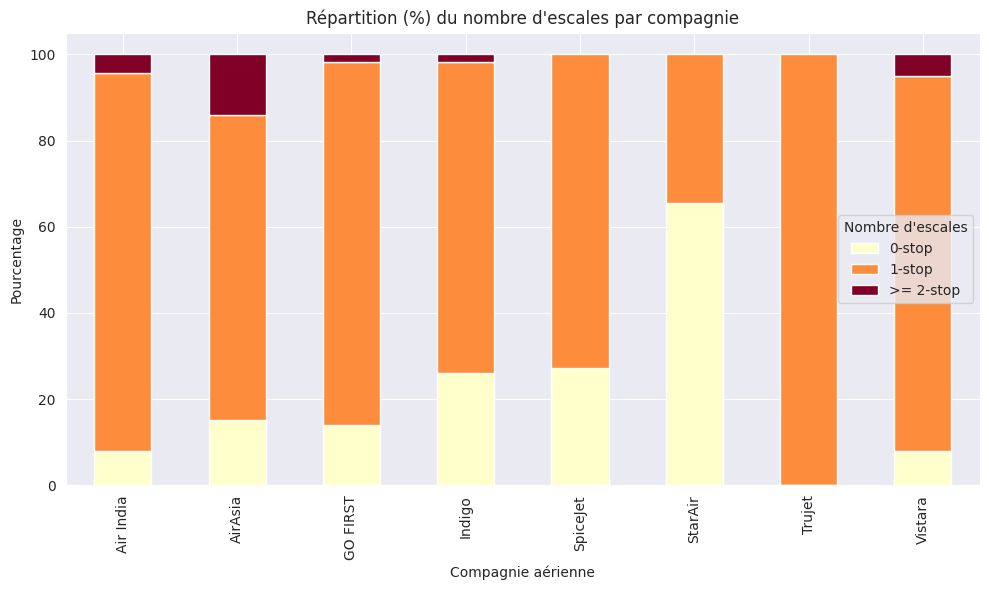

In [251]:
ct = pd.crosstab(data['airline'], data['stop'], normalize='index') * 100
ct.plot(kind='bar', stacked=True, colormap='YlOrRd', figsize=(10,6))

plt.title("Répartition (%) du nombre d'escales par compagnie")
plt.xlabel("Compagnie aérienne")
plt.ylabel("Pourcentage")
plt.legend(title="Nombre d'escales")
plt.tight_layout()
plt.show()


Ce qu'on peut retenir ici est que :
- Toutes les compagnies aériennes à l'exception de StarAir effectuent en majotité une escale lors des vols éffectués
- Seules, Air Asia, Air India et Vistara font au moins deux escales (nous avons aussi GO FIRST et Indigo qui sont une très fine minorité)
- Trujet est la seule compagnie dont 100% des trajets comptent une escale.

→ Conclusion : Toutes les compagnies sont idéales si vous devez faire escale dans une ville donnée (reste à savoir quelles compagnies font escale dans la ville voulue). Quant aux trajets directs et sans escale, il faudrait privilégier StarAir. Enfin pour des longs voyages avec au moins deux escales, Air Asia, Air India et Vistara sont idéales !

***Pour la classe business puis la classe économique, quelle est le prix moyen des vols ?***

In [252]:
# Très simplement, nous allons regrouper chaque classe de vol dans une varaible
business = data.loc[data['class'] == 'business', 'price']
economy = data.loc[data['class'] == 'economy', 'price']

print(f"Le prix moyen des vols en classe économique est {economy.mean().round(0)}")
print(f"Le prix moyen des vols en classe business est {business.mean().round(0)}")

Le prix moyen des vols en classe économique est 6572.0
Le prix moyen des vols en classe business est 52540.0


In [253]:
business.describe()

count     93487.000000
mean      52540.081124
std       12969.314606
min       12000.000000
25%       45185.000000
50%       53164.000000
75%       60396.000000
max      123071.000000
Name: price, dtype: float64

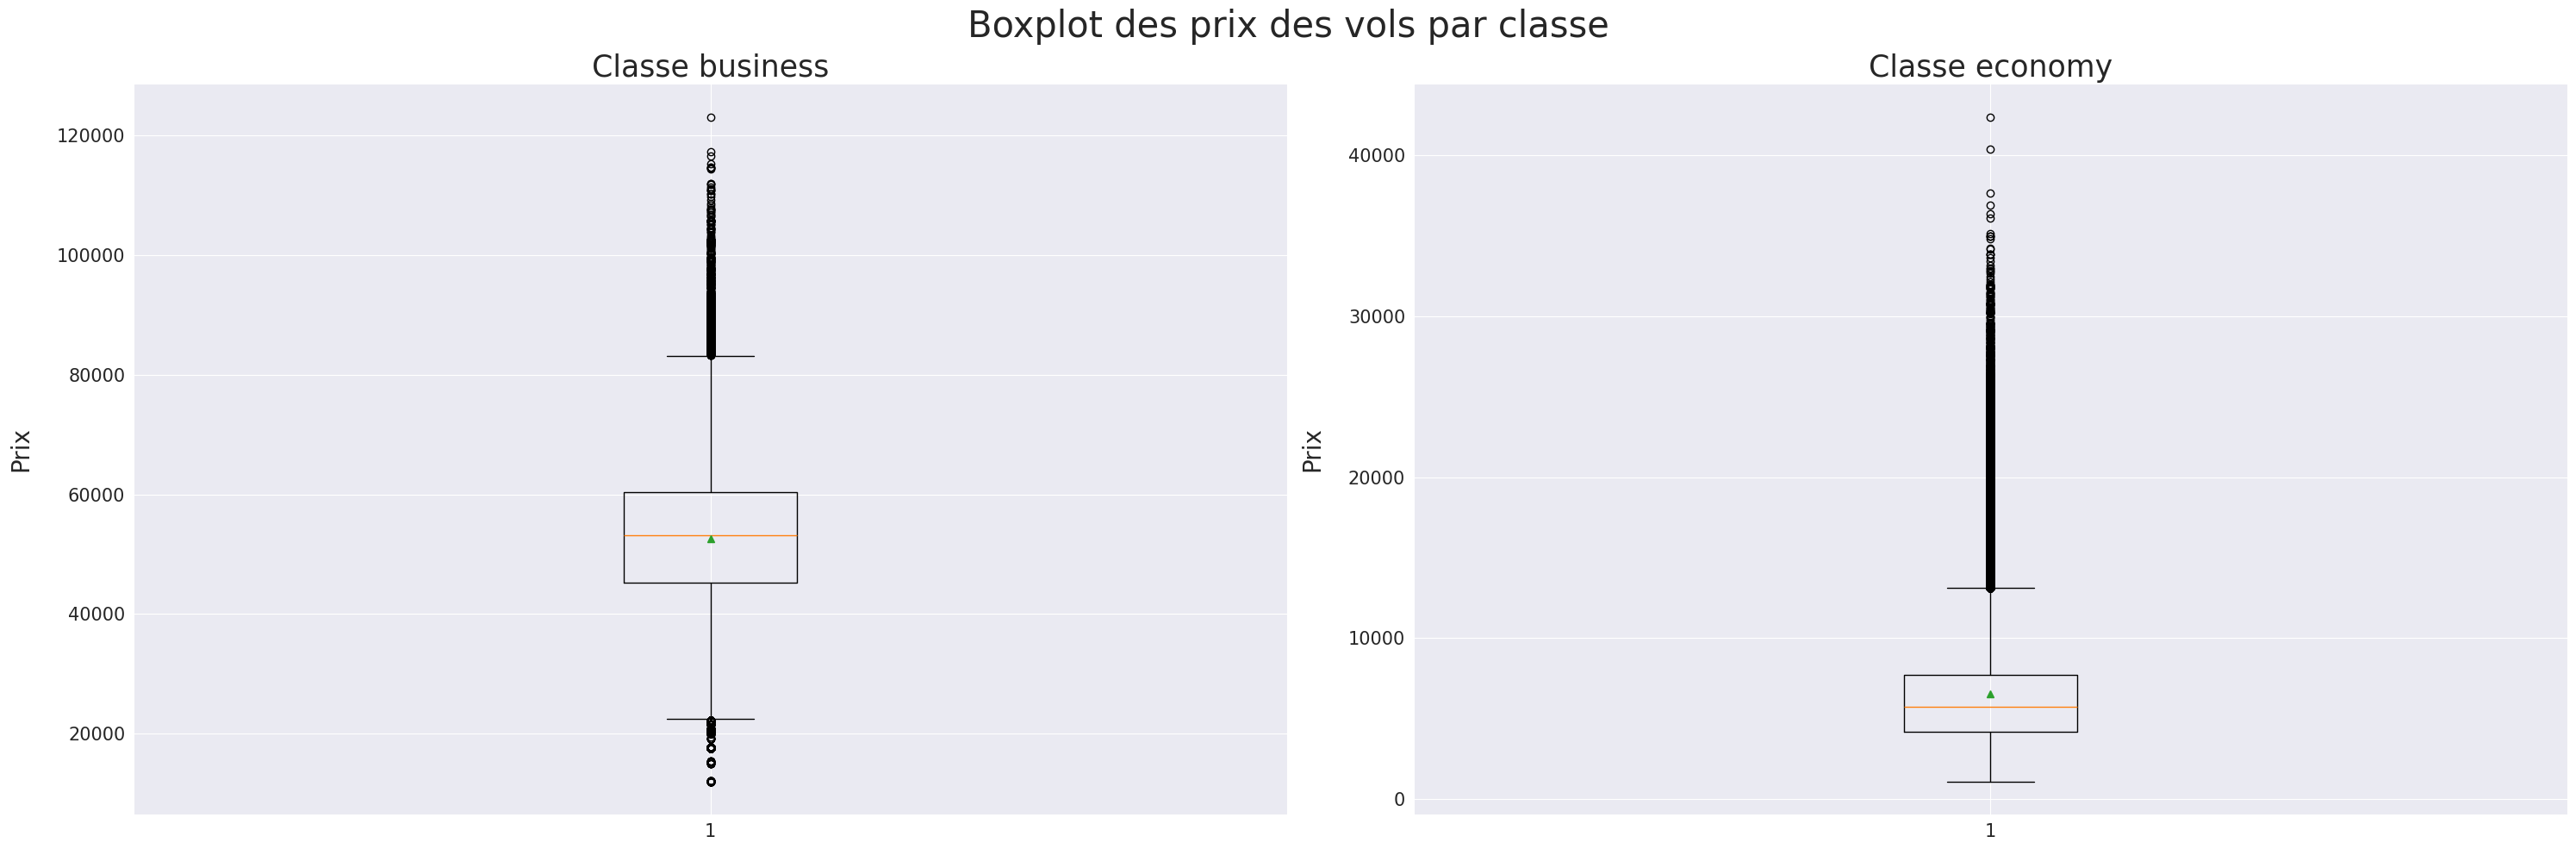

In [254]:
# Visualisation
names = ['business', 'economy']
fig, ax = plt.subplots(ncols=2, figsize=(30, 10))
fig.suptitle('Boxplot des prix des vols par classe', fontsize=30)
for i in range(2):
    ax[i].set_title(f'Classe {names[i]}', fontsize=25)
    ax[i].set_ylabel('Prix', fontsize=20, labelpad=20)
    ax[i].tick_params(axis='both', labelsize=15)

ax[0].boxplot(business, showmeans=True)
ax[1].boxplot(economy, showmeans=True)
plt.tight_layout()
plt.show()

De cette analyse, on peut remarquer que le prix des vols de la classe business sont plus chers que ceux de la classe économique, ce qui est logique. On retiendra surtout que le prix des vols en classe économique se retrouve dans un intervalle de 1000 dollars à 15000 dollars tandis que ceux de la classe business se retrouvent entre 20000 dollars et 80000 dollars (sans compter les outliers).

***Une compagnie aérienne a-t-elle des prix de vols plus chers qu'une autre ?***

In [255]:
# On regroupe les prix des vols par compagnie aérienne
grouped_price_by_airline = data.groupby("airline")['price'].mean().reset_index()
grouped_price_by_airline.sort_values(by="price", ascending=False, inplace=True)
grouped_price_by_airline

,airline,price
7,Vistara,30396.536302
0,Air India,23507.019112
4,SpiceJet,6179.278881
2,GO FIRST,5650.813480
3,Indigo,5324.326019
5,StarAir,4932.655738
1,AirAsia,4095.267576
6,Trujet,3244.634146


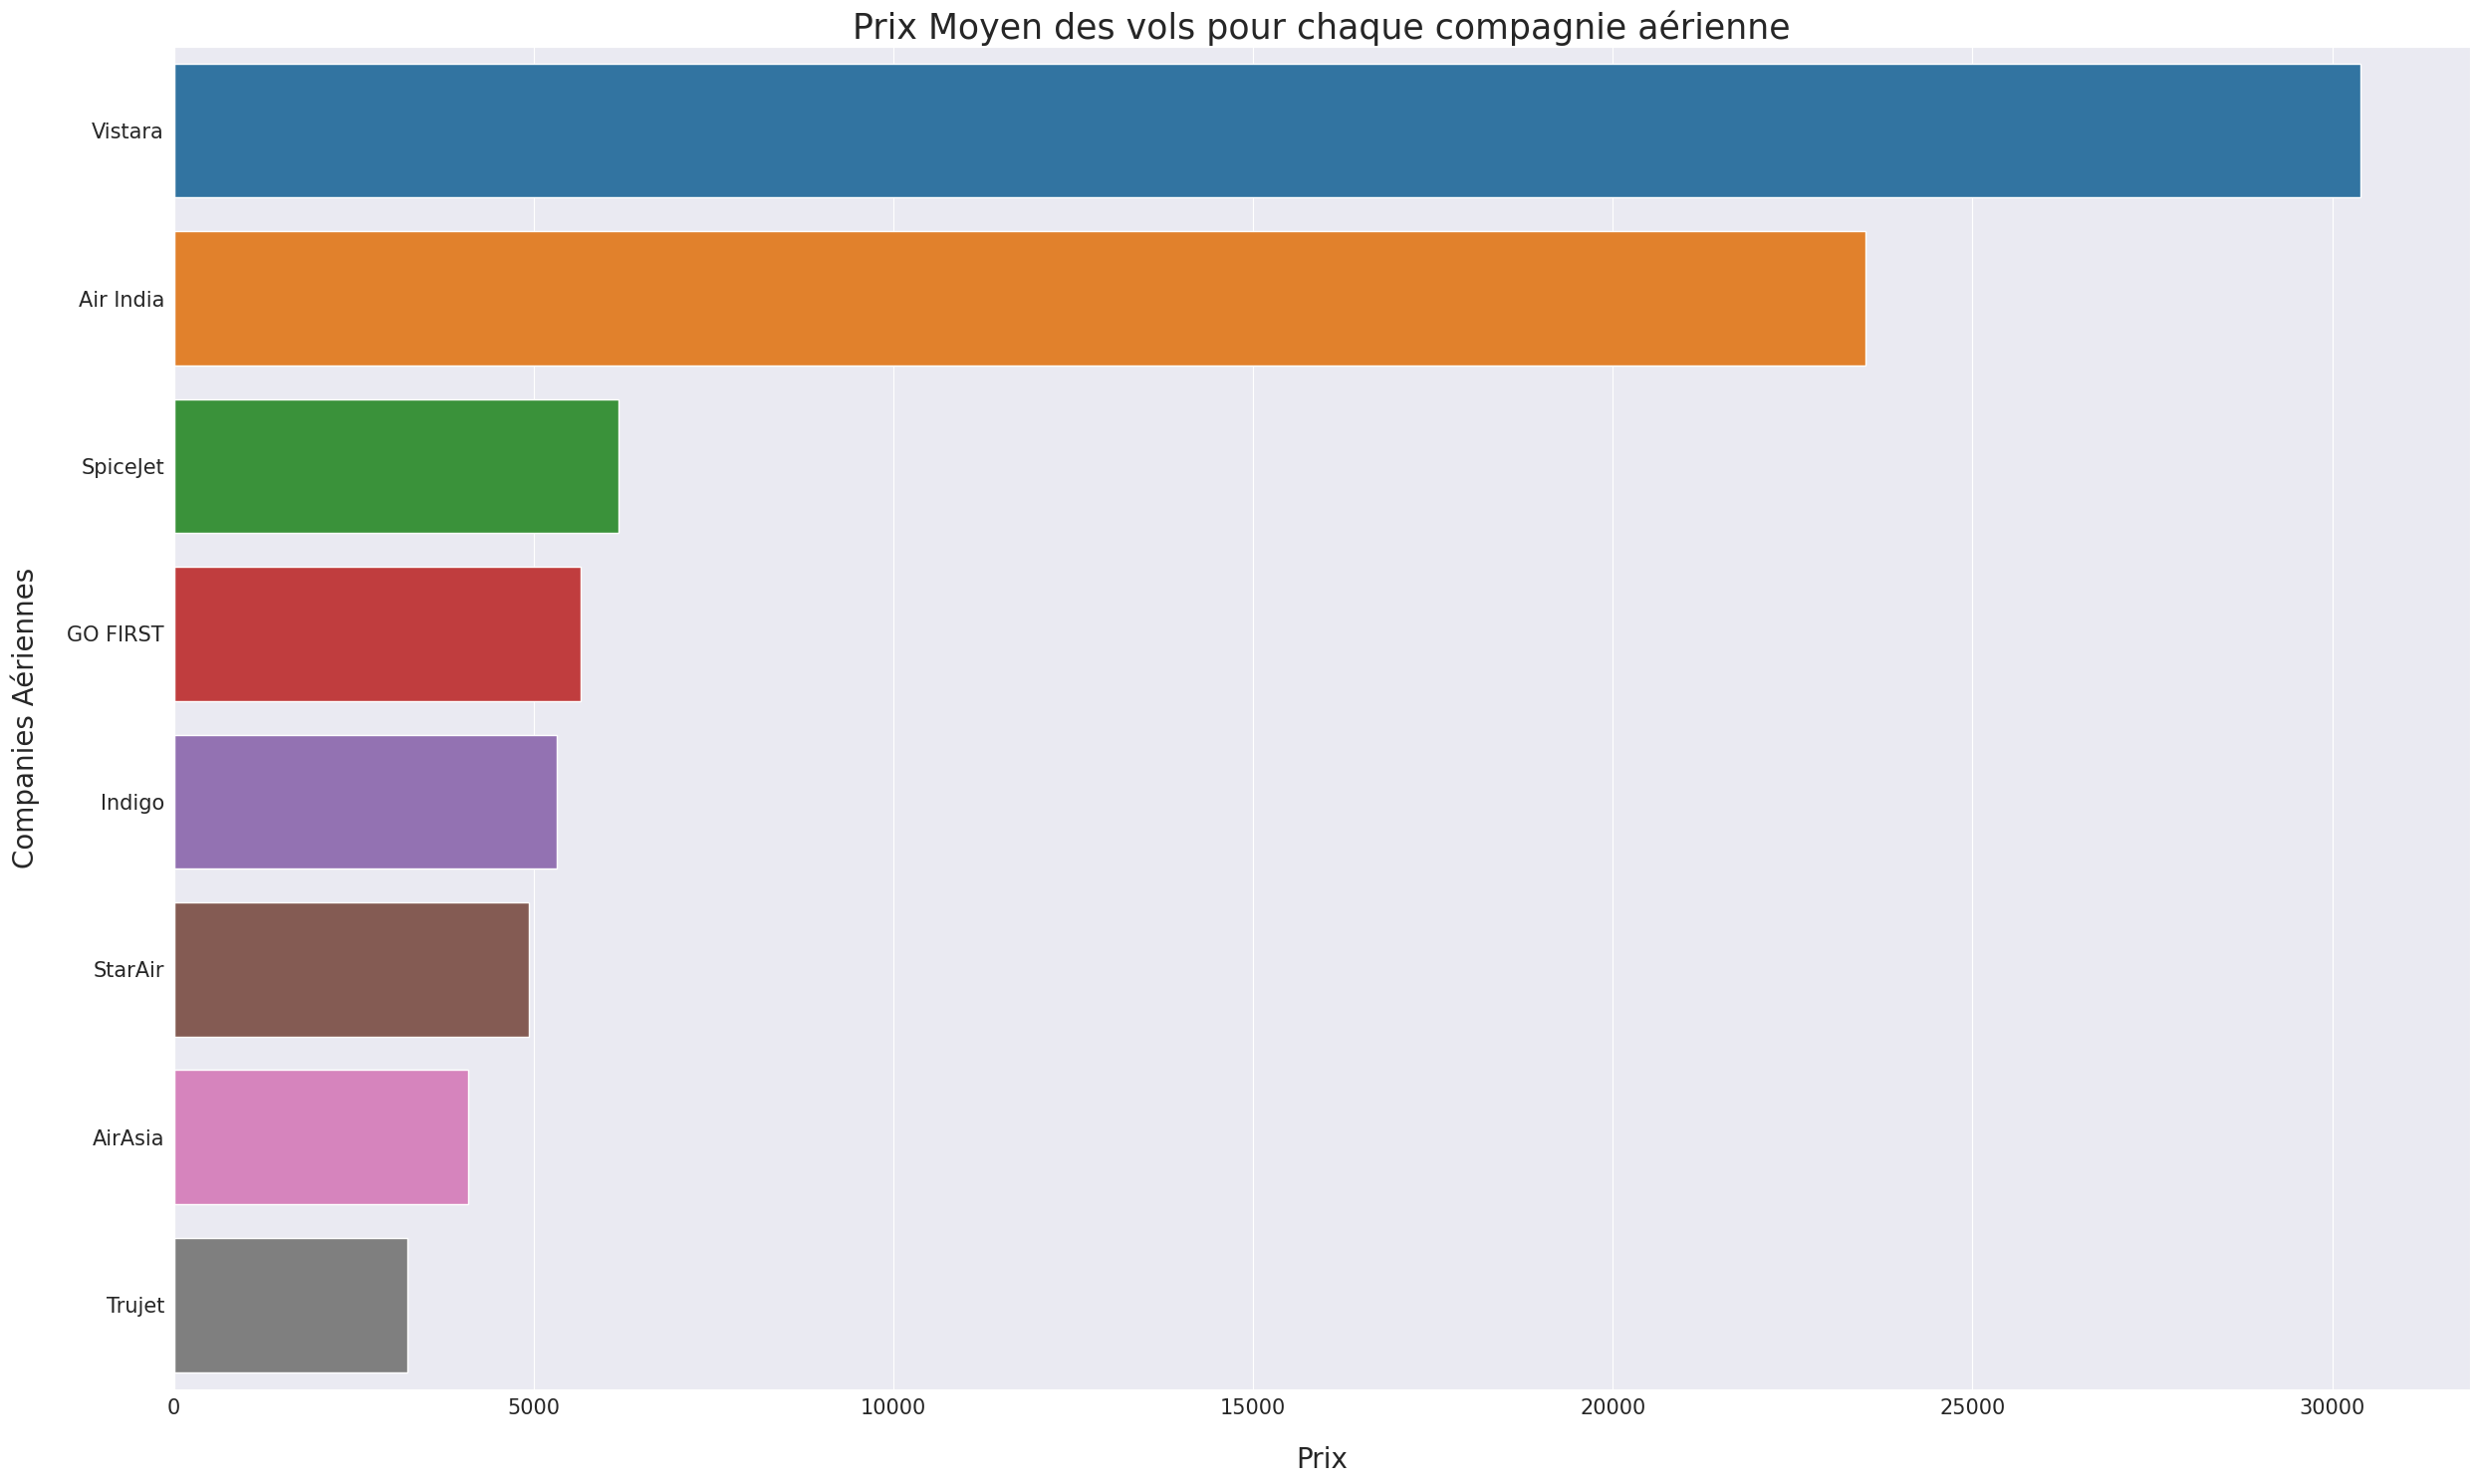

In [256]:
# Puis, on visualise avec un diagramme en barres
plt.figure(figsize=(25, 15))
plt.grid(axis="y")
plt.title("Prix Moyen des vols pour chaque compagnie aérienne", fontsize=25)
plt.xlabel("Prix", fontsize=20, labelpad=20), plt.ylabel("Companies Aériennes", fontsize=20, labelpad=20)
plt.tick_params(labelsize=15)

sns.barplot(grouped_price_by_airline, x='price', y="airline", hue="airline", palette="tab10")
plt.tight_layout()
plt.show()

On peut constater que les prix chez les grandes compagnies comme Vistara et Air India sont les plus chers. Les autres compagnies ont des prix de vols beaucoup plus bas.

→ Conclusion : Les compagnies Vistara et Air India conviendraient plus à des voyageurs avec un budget plus conséquent, surtout pour ceux en business class, tandis que les autres compagnies comme Indigo, GO FIRST, StarAir, etc, sont plus abordables pour des individus de classe moyenne.

***Les vols ont-ils tendances à démarrer à un moment T de la journée en fonction de la ville de départ ?***

(<Figure size 640x480 with 3 Axes>,
 {('Delhi', 'soir'): (0.0,
   np.float64(0.0),
   0.18156096412620787,
   np.float64(0.21959095801937564)),
  ('Delhi', 'apres-midi'): (0.0,
   np.float64(0.234975573403991),
   0.18156096412620787,
   np.float64(0.22386655325299026)),
  ('Delhi', 'matin'): (0.0,
   np.float64(0.4742267420415967),
   0.18156096412620787,
   np.float64(0.3374709251996657)),
  ('Delhi', 'aube'): (0.0,
   np.float64(0.8270822826258778),
   0.18156096412620787,
   np.float64(0.049726376959961446)),
  ('Delhi', 'midi'): (0.0,
   np.float64(0.8921932749704545),
   0.18156096412620787,
   np.float64(0.08301278914841892)),
  ('Delhi', 'nuit'): (0.0,
   np.float64(0.9905906795034889),
   0.18156096412620787,
   np.float64(0.009409320496510987)),
  ('Mumbai', 'soir'): (0.2037831863484301,
   np.float64(0.0),
   0.1802402838574228,
   np.float64(0.27056278150449137)),
  ('Mumbai', 'apres-midi'): (0.2037831863484301,
   np.float64(0.28594739688910675),
   0.1802402838574228,
   

<Figure size 2000x1800 with 0 Axes>

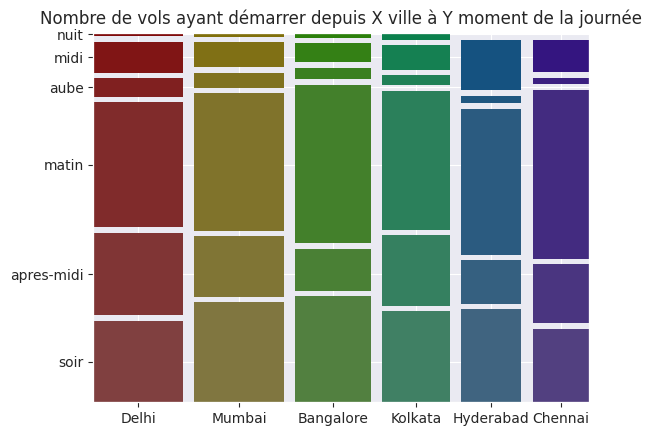

In [257]:
# Visualisons cela avec une mosaïque
from statsmodels.graphics.mosaicplot import mosaic
plt.figure(figsize=(20, 18))
mosaic(data, ['from', 'dep_time'], title="Nombre de vols ayant démarrer depuis X ville à Y moment de la journée", gap=0.025, labelizer=lambda key: "")

On peut tirer de ce graphe, que dans toutes les villes, la plupart des vols démarrent le matin. On avait déja remarqué lors de l'analyse univariée cette tendance avec laquelle les avions décollent principalement dans la matinée. C'est pareil dans toutes les villes.

→ Conclusion : Les vols ont éffectivement tendance à démarrer dans la matinée, mais cela semble indépendamment de la ville de départ

***Les villes de départ et d'arrivée influencent-elles le prix du billet de vol ?***

In [258]:
# On regroupe les prix des vols par ville de départ
grouped_price_by_from = data.groupby("from")['price'].mean().reset_index()
grouped_price_by_from.sort_values(by="price", ascending=False, inplace=True)
# On regroupe les prix des vols par ville de destination
grouped_price_by_to = data.groupby("to")['price'].mean().reset_index()
grouped_price_by_to.sort_values(by="price", ascending=False, inplace=True)

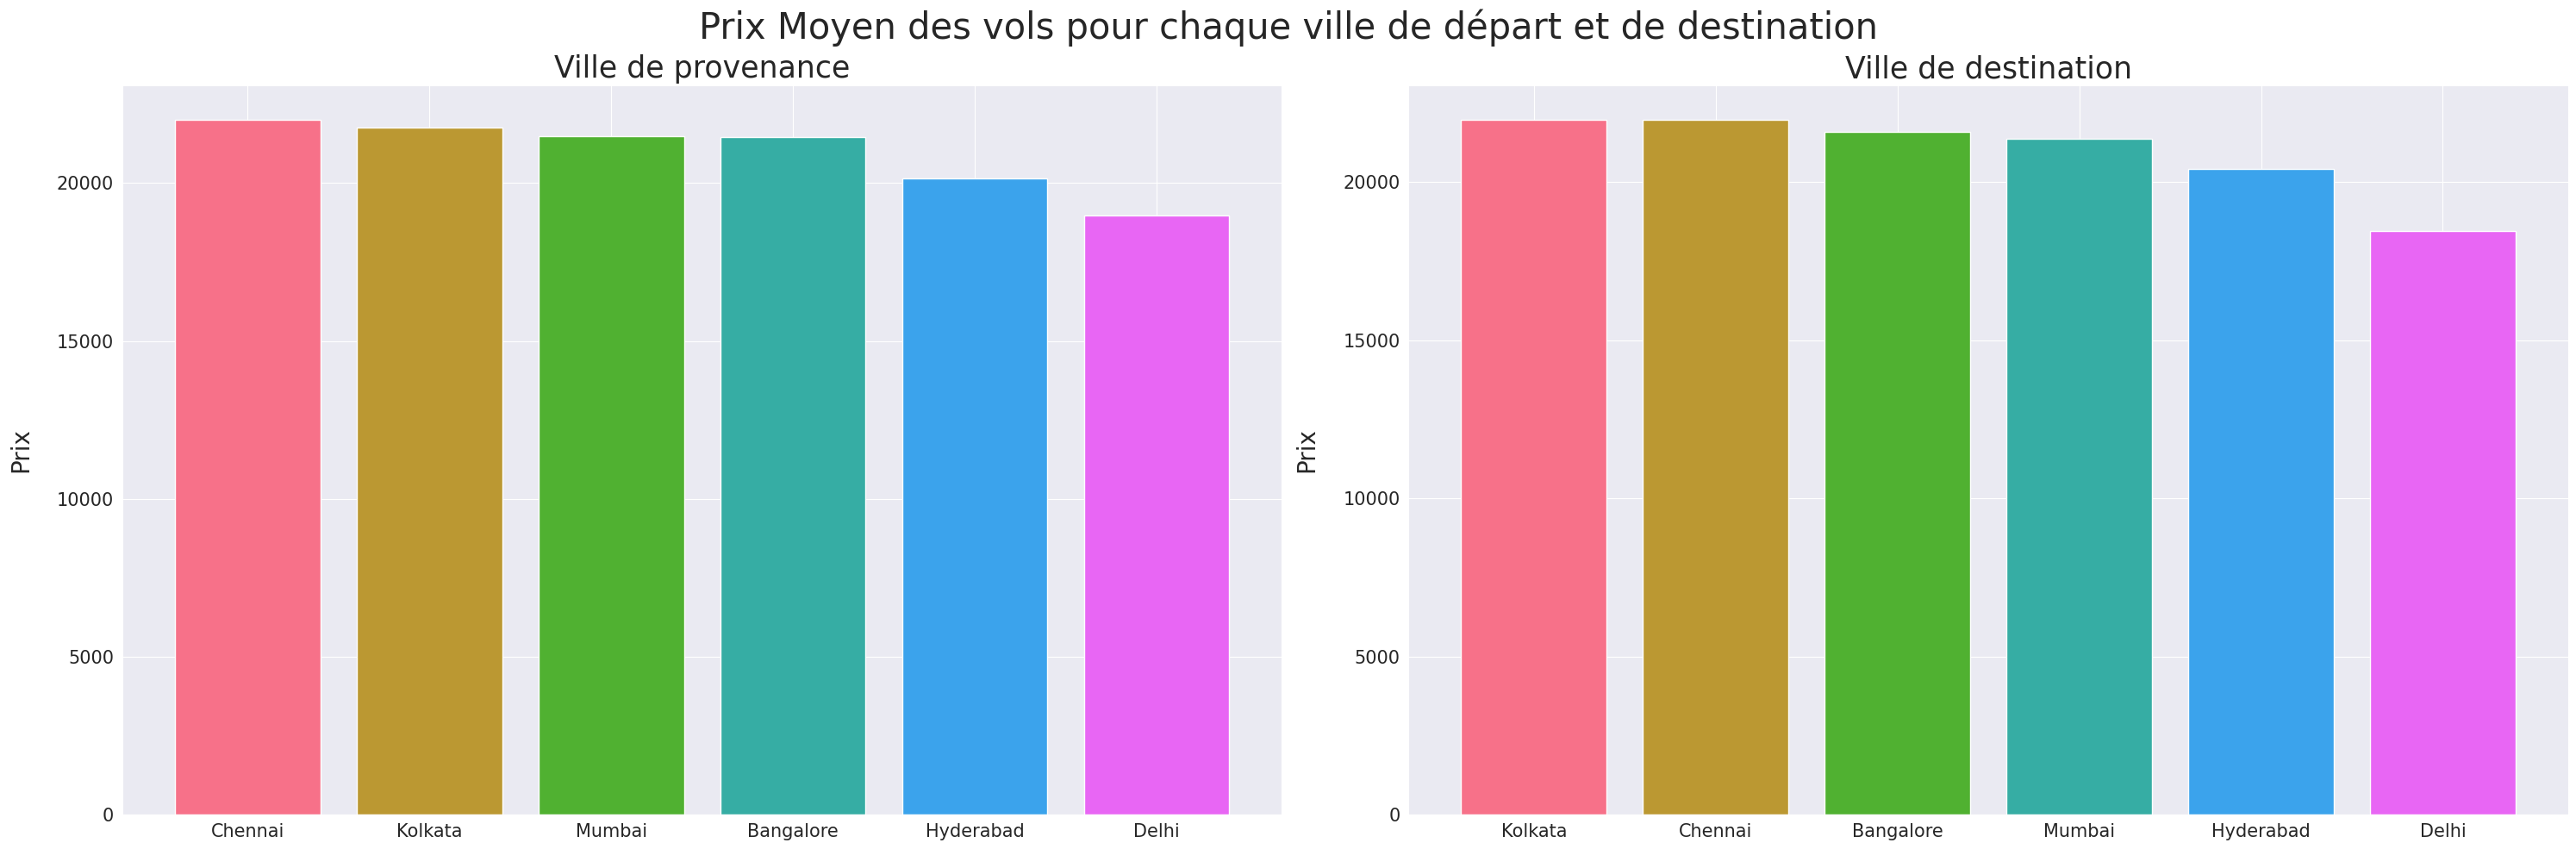

In [259]:
# Puis, on visualise avec un diagramme en barres
names = ["provenance", "destination"]
fig, ax = plt.subplots(ncols=2, figsize=(30, 10))
fig.suptitle('Prix Moyen des vols pour chaque ville de départ et de destination', fontsize=30)
for i in range(2):
    ax[i].set_title(f'Ville de {names[i]}', fontsize=25)
    ax[i].set_ylabel('Prix', fontsize=20, labelpad=20)
    ax[i].tick_params(axis='both', labelsize=15)

ax[0].bar(grouped_price_by_from["from"], grouped_price_by_from["price"], color=sns.color_palette("husl", len(grouped_price_by_from)))
ax[1].bar(grouped_price_by_to["to"], grouped_price_by_to["price"], color=sns.color_palette("husl", len(grouped_price_by_to)))
plt.tight_layout()
plt.show()

Pour les villes de provenance, il n'y a pratiquement pas de différence de prix de vols d'une ville à l'autre. Même constat pour les villes d'arrivées.

→ Conclusion : Le prix des vols est indépendant de la ville de départ comme de la ville de destination. Il n'y a donc pas de lien entre ces deux variables

***Existe-t-il un lien entre la durée du trajet et le prix du vol ?***

In [260]:
# Même process, On regroupe les prix des vols par durée de trajet
grouped_price_by_tt = data.groupby("time_taken")['price'].mean().reset_index()
grouped_price_by_tt.sort_values(by="price", ascending=True, inplace=True)

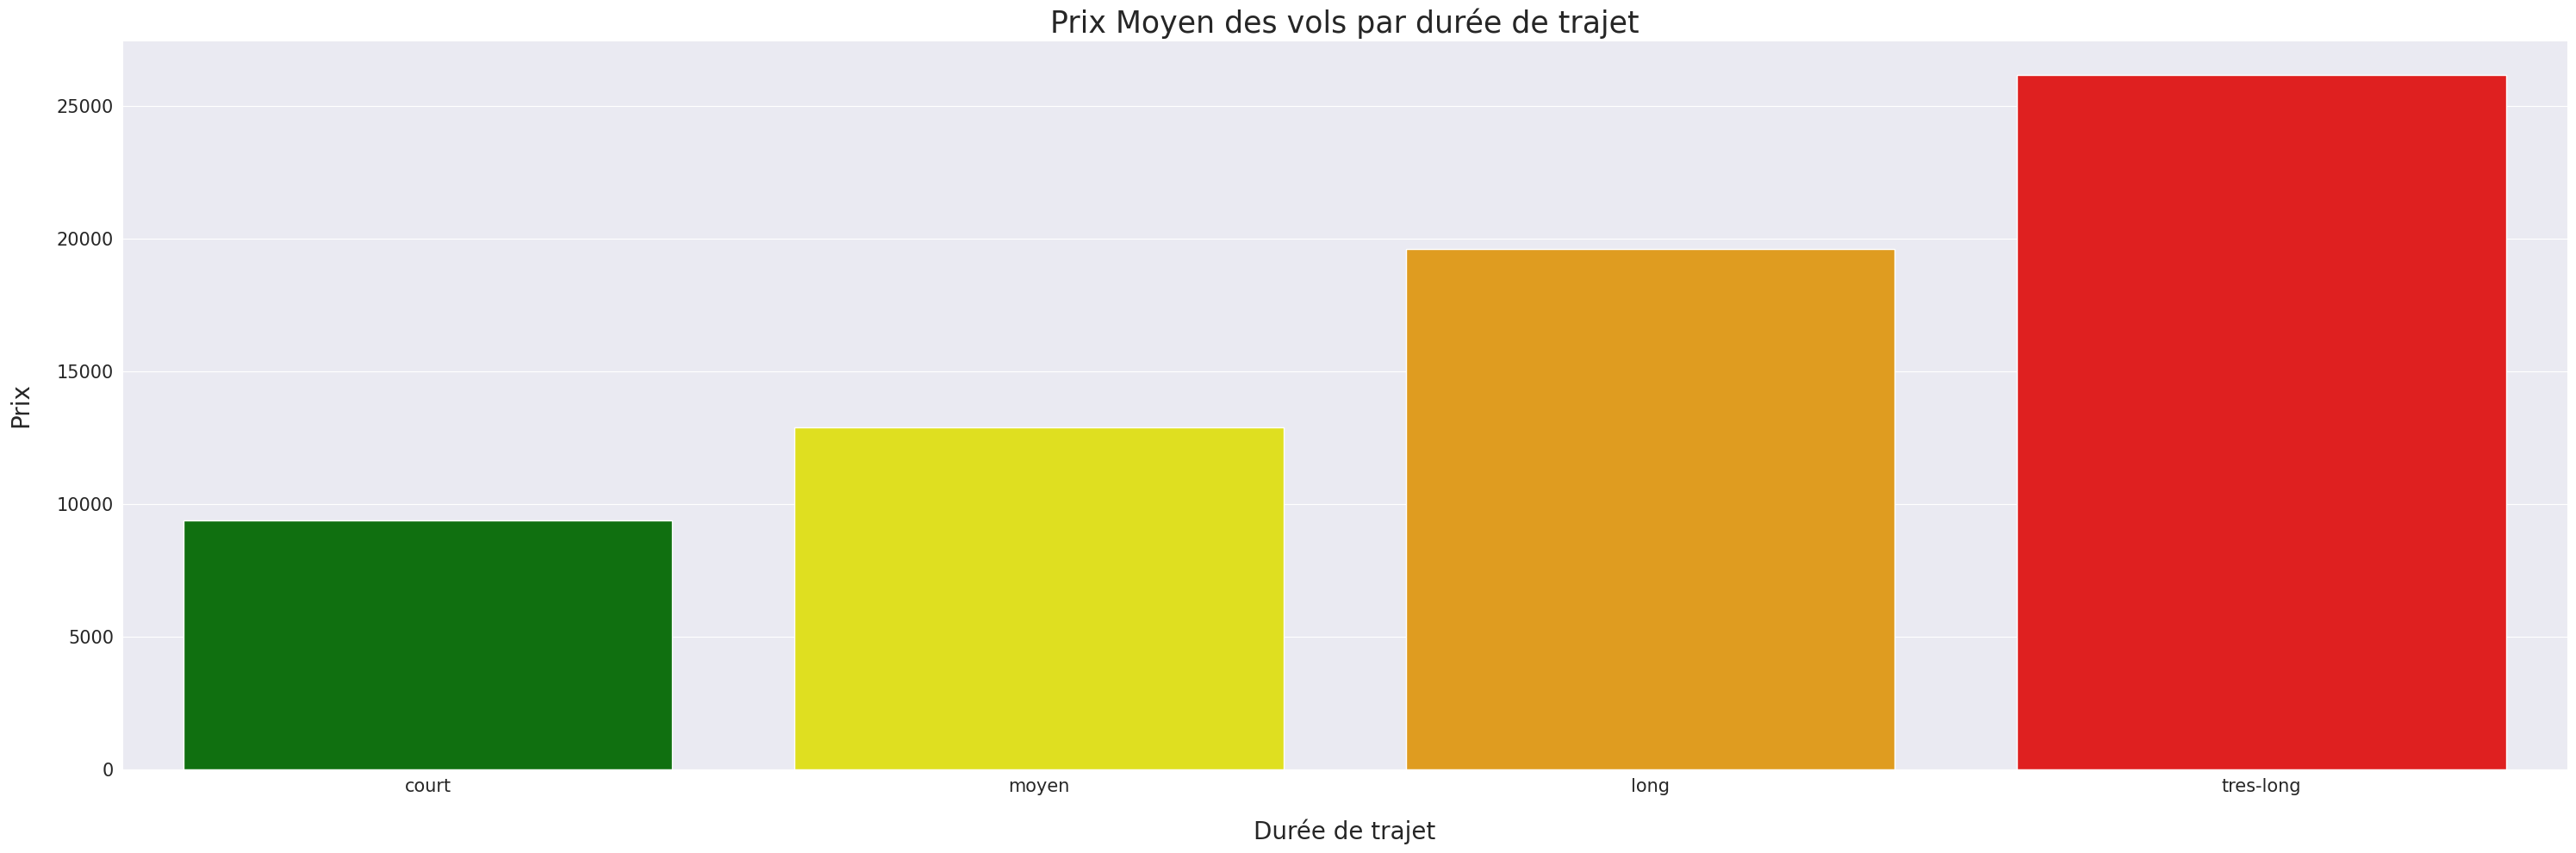

In [261]:
# Puis, on visualise
plt.figure(figsize=(30, 10))
plt.grid(axis="x")
plt.title('Prix Moyen des vols par durée de trajet', fontsize=25)
plt.xlabel('Durée de trajet', fontsize=20, labelpad=20); plt.ylabel('Prix', fontsize=20, labelpad=20)
plt.tick_params(axis='both', labelsize=15)

sns.barplot(grouped_price_by_tt, x="time_taken", y="price", hue="time_taken", palette=['green', "yellow", "orange", "red"])
plt.tight_layout()
plt.show()

→ Interprétation : Plus le trajet est long plus le prix du vol est élevé.

→ Conclusion : Il semble donc exister un lien linéaire croissant entre la durée du trajet et le prix du vol

***Le nombre d'escales influence-t-il le prix du vol ?***

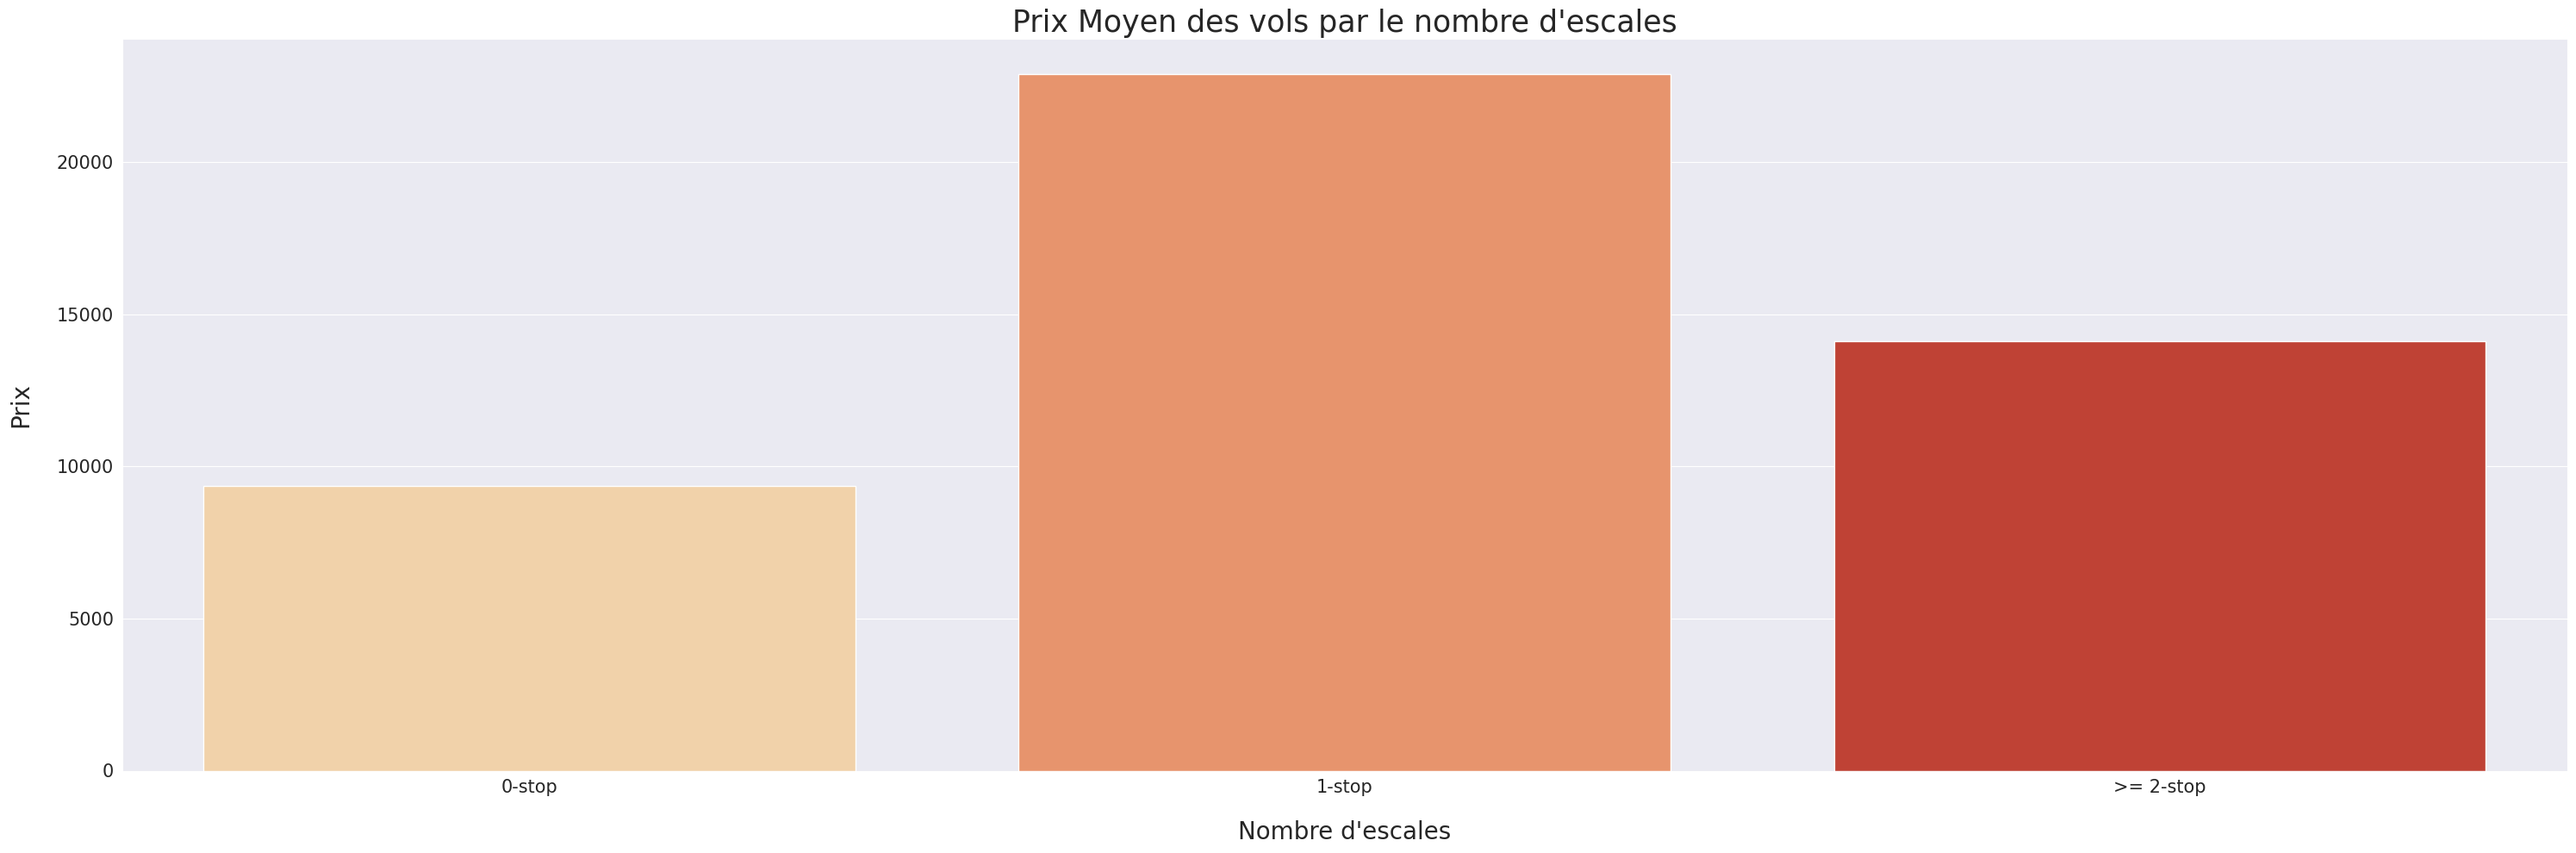

In [262]:
# Même process, On regroupe les prix des vols par le nombre d'escales
grouped_price_by_stop = data.groupby("stop")['price'].mean().reset_index()

# Puis, on visualise
plt.figure(figsize=(30, 10))
plt.grid(axis="x")
plt.title('Prix Moyen des vols par le nombre d\'escales', fontsize=25)
plt.xlabel('Nombre d\'escales', fontsize=20, labelpad=20); plt.ylabel('Prix', fontsize=20, labelpad=20)
plt.tick_params(axis='both', labelsize=15)

sns.barplot(grouped_price_by_stop, x="stop", y="price", hue="stop", palette=sns.color_palette(palette='OrRd', n_colors=len(grouped_price_by_stop)))
plt.tight_layout()
plt.show()

→ Interprétation : Ici, de ZÉRO à UNE escale, on a une croissance du prix, mais à plus de d'UNE escale le prix redescend.

→ Conclusion : Il semble ne pas exister de lien linéaire entre le nombre d'escales et le prix du vol.

Nous avons terminé notre analyse bivariée et pouvons passer aux tests statistiques pour valider ou non les hypothèses émises au cours de cette dernière.

Mais avant ça nous allons créer une nouvelle colonne nommée période. Cette colonne nous permettra de distinguer la période pendant laquelle un vol a été effectué, ce qui nous servira grandement dans la prochaine et dernière étape.

In [263]:
def set_period(date):
    if pd.Timestamp(2022, 2, 7) <= date <= pd.Timestamp(2022, 2, 13):
        return "semaine-1"
    elif pd.Timestamp(2022, 2, 14) <= date <= pd.Timestamp(2022, 2, 20):
        return "semaine-2"
    elif pd.Timestamp(2022, 2, 21) <= date <= pd.Timestamp(2022, 2, 27):
        return "semaine-3"
    elif pd.Timestamp(2022, 2, 28) <= date <= pd.Timestamp(2022, 3, 6):
        return "semaine-4"
    elif pd.Timestamp(2022, 3, 7) <= date <= pd.Timestamp(2022, 3, 13):
        return "semaine-5"
    elif pd.Timestamp(2022, 3, 14) <= date <= pd.Timestamp(2022, 3, 20):
        return "semaine-6"
    elif pd.Timestamp(2022, 3, 21) <= date <= pd.Timestamp(2022, 4, 27):
        return "semaine-7"
    elif pd.Timestamp(2022, 3, 28) <= date <= pd.Timestamp(2022, 4, 3):
        return "semaine-8"
    return np.nan


In [264]:
data["period"] = data['date']
data["period"] = data["period"].apply(set_period)

In [265]:
data.head()

,date,airline,dep_time,from,time_taken,stop,arr_time,to,price,class,period
0,2022-02-11,Air India,soir,Delhi,court,0-stop,soir,Mumbai,25612,business,semaine-1
1,2022-02-11,Air India,soir,Delhi,court,0-stop,soir,Mumbai,25612,business,semaine-1
2,2022-02-11,Air India,soir,Delhi,tres-long,1-stop,soir,Mumbai,42220,business,semaine-1
3,2022-02-11,Air India,soir,Delhi,tres-long,1-stop,nuit,Mumbai,44450,business,semaine-1
4,2022-02-11,Air India,apres-midi,Delhi,long,1-stop,nuit,Mumbai,46690,business,semaine-1


On peut sauvegarder notre dataset pour l'étape suivante

In [266]:
data.to_csv("../output/cleaned_data/data_transformed.csv", index=False)